# **House Prices Regression Predicction Model**
## **Introduction**
### Dataset Overview
The data model study below is based on Kaggle open dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

This is the US Housing dataset in Ames, Lowa. It cotains 79 features related to house information such as OverallQual, LotArea, YearBuilt and quality Condition.

### Objective
The goal is to predict the housing price by training a regression model with the provided data and explain what are the key factors affecting the house price.

### Model Training Flow
1. Data Cleaning & Exploration
2. Data Transformation
3. Model Selection
4. Base Model Training
5. Feature Engineering and Model Finetune
6. Model Enhancement
6. Conclusion

## **Import Libaries**
Common libraries for data plotting and model training.
Optuna library is used for model hyperparameter optimization.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import Ridge as RG
from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.01)
Lars = linear_model.Lars()
LassoLars=linear_model.LassoLars(alpha=0.01)
from xgboost import XGBRegressor as XGBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR

import optuna

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn import metrics
#from sklearn.model_selection import ShuffleSplit
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import precision_score
#from RegscorePy import *
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import shap

#from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


## **1. Data Cleaning & Exploration**
### **Section Summary:**
The Data provided is a single file Train.csv (1,460 rows x 81 columns). The target response is 'SalePrice' accros 2006 to 2010. The 'SalePrice' distribution is positively skewed due to few extrem high 'SalePrice'.

![alt text](Assets/SalePrice.png)

Data exploration has found several important features:
1. For numerical features, correlation score is assessed, 'OverallQual' has 0.79 correlation to 'SalePrice'

![alt text](Assets/SalePriceVsOverallQual.jpg)

2. For categorical features, t-test is used to check any abnormal distribution of 'SalePrice' by categorical feature, under 'ExterQual' feature, 'Excelent' has higher SalePrice than 'Good', and so on.

![alt text](Assets/ExterQual.png)

### **Section Highlights:**
Good data quality, no observable duplications or single value data.

Missing data was found when checking for ‘NaN’ value. However based on data description, those are true null. For example if the house does not have the ‘pool’, the ‘pool quality’ will be null. The null will be handled duuring data transformation.

In [42]:
df=pd.read_csv("train.csv")

Quick check has found 'NaN' in train data

In [43]:
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

High level understanding on data. The target response is 'SalePrice'. It has positive skew and high outlier price.

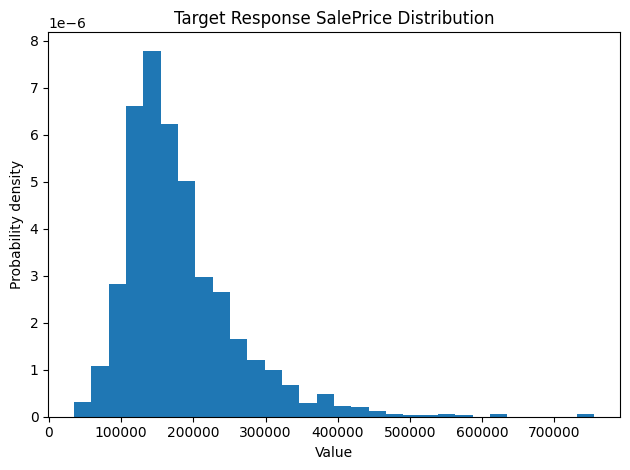

In [44]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df['SalePrice'], 30, density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Probability density')
ax.set_title('Target Response SalePrice Distribution')
fig.tight_layout()
plt.show()

In [45]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

No duplication.

In [46]:
df.duplicated().sum()

0

At least has two unique values.

In [47]:
df.nunique().sort_values(ascending=False)

Id            1460
LotArea       1073
GrLivArea      861
BsmtUnfSF      780
1stFlrSF       753
              ... 
HalfBath         3
Street           2
CentralAir       2
Utilities        2
Alley            2
Length: 81, dtype: int64

There are many features having high missing values.

In [48]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

Create function to investigate the missing values.

In [49]:
def missing_feat(df):
    null_col=pd.DataFrame(columns=['Feature','Total Transaction','Transaction with Missing Value','Missing %'])
    null_col_index=0
    for i in df.isnull().sum().sort_values(ascending=False).index:
        null_col.loc[null_col_index]=[i,
                                    len(df),
                                    df[i].isnull().sum(),
                                    float(df[i].isnull().sum()/len(df))*100,
                                    ]
        null_col_index=null_col_index+1

    print('Features with missing values')
    display(null_col[null_col['Missing %']>0])

    fig = px.ecdf(null_col, x="Missing %",marginal="histogram",title="Cumulative Distribution of Feature(column) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Feature Density',
                        )  

    fig.show()

    return null_col

About 25% features contain missing feature, from ~5% to ~95% missing.

In [50]:
feat_missing_df=missing_feat(df)

Features with missing values


Feature  Total Transaction  Transaction with Missing Value  Missing %
0         PoolQC               1460                            1453  99.520548
1    MiscFeature               1460                            1406  96.301370
2          Alley               1460                            1369  93.767123
3          Fence               1460                            1179  80.753425
4     MasVnrType               1460                             872  59.726027
5    FireplaceQu               1460                             690  47.260274
6    LotFrontage               1460                             259  17.739726
7    GarageYrBlt               1460                              81   5.547945
8     GarageCond               1460                              81   5.547945
9     GarageType               1460                              81   5.547945
10  GarageFinish               1460                              81   5.547945
11    GarageQual               1460                              81   5.547945
12  BsmtFinType2               1460                              38   2.602740
13  BsmtExposure               1460                              38   2.602740
14      BsmtQual               1460                              37   2.534247
15      BsmtCond               1460                              37   2.534247
16  BsmtFinType1               1460                              37   2.534247
17    MasVnrArea               1460                               8   0.547945
18    Electrical               1460                               1   0.068493

There are features with almost 90% missing values! However the data description file provided by dataset explain certain housing feature are not available, hence it is NaN in the dataset. For example, 'PoolQC' is the quality assessment for the pool:

In [51]:
df['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

There is also feature related to pool area 'PoolArea'. For 'PoolArea' more than 0 (i.e. the house has pool), there are no missing 'PoolQC', in another words, the 'PoolQC' is available only for house with pool. 'Ex' is Excellent, 'Fa' is Fair, etc...

In [52]:
df[['PoolArea','PoolQC']][df['PoolArea']>0]

PoolArea PoolQC
197        512     Ex
810        648     Fa
1170       576     Gd
1182       555     Ex
1298       480     Gd
1386       519     Fa
1423       738     Gd

Similarly for 'MiscFeature', it is miscellaneous feature which is not covered in other categories. It should be kept as well. 'MiscVa' is the value of the 'MiscFeature'.

In [53]:
df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [54]:
df[['MiscVal','MiscFeature']][df['MiscVal']>0]

MiscVal MiscFeature
5         700        Shed
7         350        Shed
16        700        Shed
17        500        Shed
51        400        Shed
84        700        Shed
95        480        Shed
98        400        Shed
99        400        Shed
106       450        Shed
214       450        Shed
249       500        Shed
250       450        Shed
335       700        Shed
338       400        Shed
346     15500        Gar2
392      1200        Shed
439       800        Shed
499       480        Shed
502       400        Shed
510      2000        Shed
539      2000        Shed
589       600        Shed
611       500        Shed
626       600        Shed
634       600        Shed
705      3500        Othr
725       500        Shed
733       400        Shed
760       450        Shed
766       500        Shed
767      1300        Shed
786      1200        Shed
794       500        Shed
800       400        Shed
812        54        Shed
813       500        Shed
867       400        Shed
878       400        Shed
890      2000        Shed
912       620        Shed
953       400        Shed
1061      560        Shed
1076      500        Shed
1083      700        Shed
1171     1400        Shed
1210      400        Shed
1230     8300        Gar2
1252      600        Shed
1328     1150        Shed
1386     2000        TenC
1457     2500        Shed

Similarly,
1. 'Alley': Type of alley access
2. 'Fence': Fence quality
3. 'MasVnrType': Masonry veneer type; 'MasVnrArea': Masonry veneer area in square feet
4. 'FireplaceQu': Fireplace quality; 'Fireplaces': Number of fireplaces
5. 'LotFrontage': Linear feet of street connected to property
6. 'GarageYrBlt': Year garage was built; 'GarageType': Garage location; 'GarageCond': Garage condition

In conclusion, these are valid data and do not have to remove them. Data transformation will be applied on the NaN values before model training.

In [55]:
#Not used
def missing_row(df):
    null_row=pd.DataFrame(columns=['Row ID','Total Feature','Feature With Missing Value','Missing %'])
    null_row_index=0
    for i in range(len(df)):
        if df.iloc[i].isnull().sum()>0:
            null_row.loc[null_row_index]=[df['Id'][i],
                                        len(df.columns),
                                        df.iloc[i].isnull().sum(),
                                        float(df.iloc[i].isnull().sum()/len(df.columns))*100,
            ]
            null_row_index=null_row_index+1

    print('Transaction with missing feature value')
    display(null_row.sort_values(ascending=False,by='Missing %'))

    fig = px.ecdf(null_row, x="Missing %",marginal="histogram",title="Cumulative Distribution of Transaction (row ID) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Row Density',
                        )
            
    fig.show()

    return null_row

Moving to data exploration. First thing to find which are numeric and categorical features:

Drop 'Id' and 'SalePrice' befire feature transformation

In [58]:
feat_df=df.drop(['Id','SalePrice'],axis=1)

In [59]:
cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
cat_feat.sort_values()

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [60]:
num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
num_feat.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

'MSSubClass' is int type but it is supposed to be categorical, hence it is grouped under cat_feat
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [61]:
num_feat=num_feat.drop('MSSubClass')
num_feat

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [62]:
cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

Create conversion function to convert the quality with ordinary label.
1. Ex	Excellent     ->5
2. Gd	Good   ->4
3.TA	Typical - slight dampness allowed  ->3
4. Fa	Fair - dampness or some cracking or settling     ->2
5. Po	Poor - Severe cracking, settling, or wetness     ->1
6. NA	No Basement   ->0

For numerical feature, quick check on the correlation with the target response 'SalePrice':

In [63]:
#interactive corrrelation heatmap for numberic feat.Roughly check the correlation with target SalePrice, and their intercorrelation
def corr_map(df,included_col,target_response):
    corr_df=df
    for i in corr_df.columns:
        if i not in included_col:
            corr_df=corr_df.drop([i],axis=1)
    
    corr_df=pd.concat([corr_df,df[target_response]],axis=1)

    print('Correlation score with SalePrice:')
    display(corr_df.corr()['SalePrice'].sort_values(ascending=False))
    fig = px.imshow(corr_df.corr(),
                    width=1200,
                    height=800,
                    #text_auto=True,
                    title='Correlation Heatmap'
                    )
    fig.show()
    return corr_df.corr()

### Data visualization
'OverallQual', 'GrLivingArea' are the top 2 numerical features with more than +0.7 corretion score

In [64]:
num_feat_corr=corr_map(df,num_feat,'SalePrice')

Correlation score with SalePrice:


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

'OverallCond' is rating of overall material and finishing condition (1 to 10), while 'GrLivArea' is 'above grade (ground) living area square feet'. In scatter plot below, Y axis is the 'SalePrice', X axis is the 'GrLivArea' and the color intensity follow the 'OverallCond'. It is clear that with larger above grade living area and better overall condition, the sale price is higher.

In [65]:
fig = px.scatter(df, x='OverallQual',y='SalePrice',color='GrLivArea')
fig.show()

The t-test function select a pair of subgroups from categorical feature to perform ANOVA test baseed on the target response 'SalePrice'. For categorical features, t-test will be used to see if any abnormal distinction is found.

In [66]:
#convert feat subgroup into series for t-test
def series_dict(df1):
    a={}
    for i in df1.index:
        if df1.iloc[i][0] not in a:
            a.update({df1.iloc[i][0]:[df1.iloc[i][1]]})
        if df1.iloc[i][0] in a:
            a[df1.iloc[i][0]].append(df1.iloc[i][1])
    return a

#t-test for the feature value from series
def series_ttest2(a):
    i_keys=list(a.keys())
    t_result=pd.DataFrame(columns=['feat_var1','feat_var2','p value','t-statistic','df'])
    index=0
    for i in range(len(i_keys)):
        if i+1<len(i_keys):
            for k in range(i+1,len(i_keys)):
                t=stats.ttest_ind(a[i_keys[i]],a[i_keys[k]])
                t_result.loc[index]=[str(i_keys[i]),str(i_keys[k]),t.pvalue,t.statistic,t.df]
                index=index+1
    return t_result

In [67]:
#t-test feature feat from dataframe
def feat_ttest(df,feat,target_response):
    sig_result=pd.DataFrame(columns=['feat','at least one pair feat_val reject h0','feat_val1','feat_val2','p value','statistic','degree of freedom'])
    sig_result_index=0
    for i in feat:
        df1=df[[i,target_response]]
        a=series_dict(df1)
        t_result=series_ttest2(a)
        t_result_min_p_index=t_result.idxmin()[2]
        #print(i,t_result.iloc[t_reult_min_p_index][2])
        if t_result.iloc[t_result_min_p_index][2]<0.05:
            h0_result=True
        if t_result.iloc[t_result_min_p_index][2]>0.05:
            h0_result=False
        sig_result.loc[sig_result_index]=[i,
                                          h0_result,
                                          t_result.iloc[t_result_min_p_index][0],
                                          t_result.iloc[t_result_min_p_index][1],
                                          t_result.iloc[t_result_min_p_index][2],
                                          t_result.iloc[t_result_min_p_index][3],
                                          t_result.iloc[t_result_min_p_index][4],
                                          ]
        sig_result_index=sig_result_index+1
        
    return sig_result.sort_values(by=['p value'])

The series_ttest2 function is used to check individual categorical feature t-test result.
For example for 'ExterQual', all feat var comparisons are showing very low p values.
The top 5 features only have 2 degrees of fredom, the sample sizes are too small, should not be considered true distinction;
'ExterQual','KitchenQual' and other quality related features have shown the there are distinction between 'TA' (typical or average) and 'Ex' (Excellent). Example is shown below, where 'Ex' has much higher SalePrice than 'TA':

In [68]:
cat_feat_result=feat_ttest(df,cat_feat,'SalePrice')
cat_feat_result.style.format({'p value': '{:.2g}','statistic':'{:.2f}','degree of freedom':'{:.0f}'})

In [69]:
a=series_ttest2(series_dict(df[['ExterQual','SalePrice']]))
a.sort_values(by=['p value']).style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

viz_response_by_feat_category will plot all the category feature in violin plot. Example for 'ExterCond' (Exterior material quality) is shown below:

![alt text](Assets/ExterQual.png)

viz_response_by_feat_category function will plot the features found reject the h0 hypothesis.

In [70]:
def viz_response_by_feat_category(df,ttest_result,target_response):
    for i in ttest_result['feat']:
        plt.figure(figsize=(10,5))
        sns.violinplot(df,x=i, y=target_response)
        plt.title(f"{i} vs {target_response}")
        plt.xticks(rotation=90)

In [ ]:
viz_response_by_feat_category(df,cat_feat_result,'SalePrice')

Deeper look on individual feature
Inspect feature value normality by normal test and viz

In [71]:
def viz_series_dist(df,feat,target_response):
    df1=df[[feat,target_response]]
    a=series_dict(df1)
    for i in a.keys():
        nor=stats.normaltest(a[i])
        print('feature:',feat,'feat_val:',i,': p value:%.2g statistic:%.2f'%(nor.pvalue,nor.statistic))
        
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(a[i], 30, density=True)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability density')
        ax.set_title(f'{feat}_Feature_Value: {i} Distribution')
        fig.tight_layout()
        plt.show()
    

Most of the 'ExterQual' values are normally distributed

feature: ExterQual feat_val: Gd : p value:7.9e-48 statistic:216.92


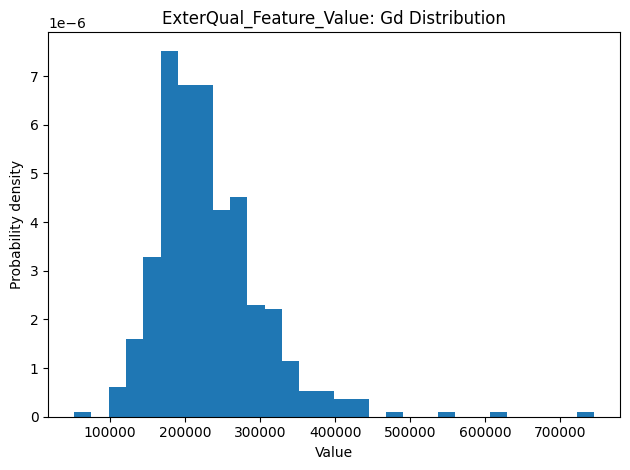

feature: ExterQual feat_val: TA : p value:2.8e-47 statistic:214.35


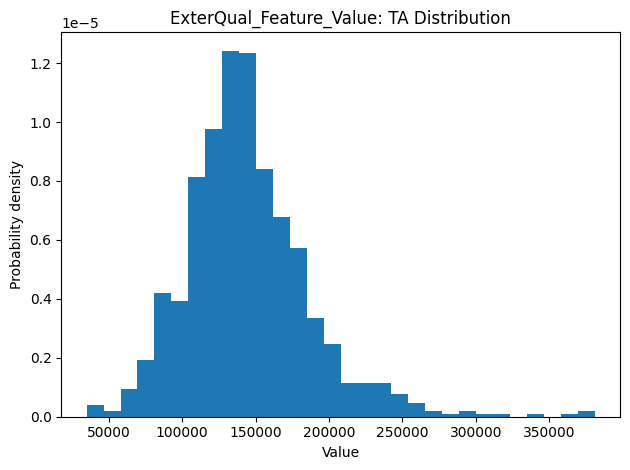

feature: ExterQual feat_val: Ex : p value:0.011 statistic:8.97


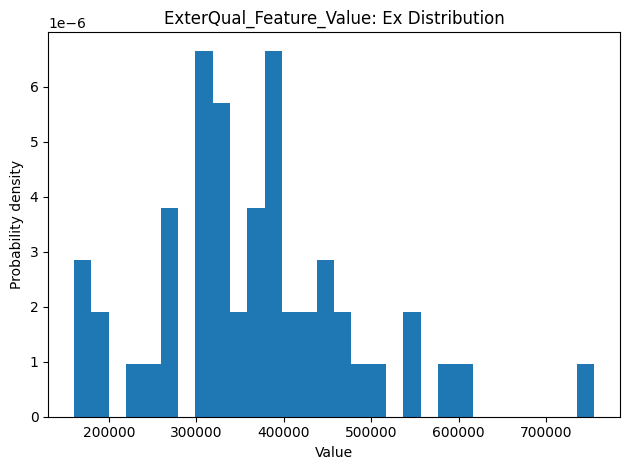

feature: ExterQual feat_val: Fa : p value:0.0018 statistic:12.69


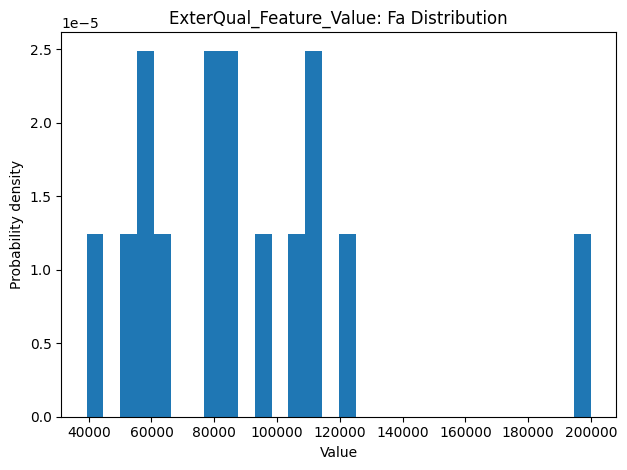

In [72]:
viz_series_dist(df,'ExterQual','SalePrice')

## **2. Data Transformation & Spliting**
### **Summary:**
The data description provided reveals that certain categorical features are rating related (Poor, Fair, Good etc), they will be converted into ordinal values. New features related age is created here (supposed to be created during 'Feature Engineering' step) since by the common sense they should be useful features for house price prediction.
### **Section Highlights:**
Data Trasnformation:
1. Rating related categorical feature-> Label encoder
2. Binary categorical feature-> Label encoder
3. Multi values categorical feature-> One-hot encoder
4. Numerical feature-> Robust Scaler
5. Special numerical feature 'MSSubClass' number is related to house class code, one-hot encoder is used instead of Robust Scaler

Data Split:
Data set provides single train.csv file. This is split and saved into train and test csv files. Following model performance assessment will be more consistent as it uses same train and test data set. Two data split approaches are used:
1. Random Split: Conventional 80/20 random split.
2. Time-Based Split: Sort the data by time ascending and split into 80/20, where the latest 20% data are Test Data.

Time-Based Split is explore during model enhancement to improve model generalization.


Based on data description, convert various categorical data into rating (int) data, and for featur values without the specic feature, fill null with zero (eg: for no garage, GarageBuilt Yr=0)

In [73]:
def df_conversion(df):
    tr=df.copy()    
    conversion1_feat=['ExterQual',
                 'ExterCond',
                 'BsmtQual',
                 'BsmtCond',
                 'HeatingQC',
                 'KitchenQual',
                 'FireplaceQu',
                 'GarageQual',
                 'GarageCond',
                 'PoolQC',
                 ]
    tr1=tr[conversion1_feat]
    for i in tr1.columns:
        tr1=tr1.replace(
            {
                np.nan:0,
                'Po':1,
                'Fa':2,
                'TA':3,
                'Gd':4,
                'Ex':5
            }
        )

    conversion2_feat=['BsmtExposure',
                  ]
    tr2=tr[conversion2_feat]
    for i in tr2.columns:
        tr2=tr2.replace(
            {
                np.nan:0,
                'No':1,
                'Mn':2,
                'Av':3,
                'Gd':4,
            }
        )

    conversion3_feat=['BsmtFinType1',
                  'BsmtFinType2',
                  ]
    tr3=tr[conversion3_feat]
    for i in tr3.columns:
        tr3=tr3.replace(
            {
                np.nan:0,
                'Unf':1,
                'LwQ':2,
                'Rec':3,
                'BLQ':4,
                'ALQ':5,
                'GLQ':6
            }
        )

    conversion4_feat=['Fence']
    tr4=tr[conversion4_feat]
    for i in tr4.columns:
        tr4=tr4.replace(
            {
                np.nan:0,
                'MnWw':1,
                'GdWo':2,
                'MnPrv':3,
                'GdPrv':4,
            }
        )

    conversion5_feat=['LotFrontage',
                      'GarageYrBlt',
                      'MasVnrArea',
                      'estimated_garage_age(yr)',
                      'estimated_garage_age((month)',
                      #'Electrical'
                      ]
    tr5=tr[conversion5_feat]
    for i in tr5.columns:
        tr5=tr5.replace(
            {
                np.nan:0,
            }
        )

    return pd.concat([tr1,tr2,tr3,tr4,tr5],axis=1)


In [75]:
a=df.copy()

In [76]:
fig = px.box(a, x='YrSold',y='SalePrice')
fig.show()

In [77]:
fig = px.box(a, x='MoSold',y='SalePrice')
fig.show()

In [78]:
fig = px.scatter(a, x='YearBuilt',y='SalePrice')
fig.show()

In [79]:
a['estimated house age(month)']=(a['YrSold']*12+a['MoSold'])-(a['YearBuilt']*12)
fig = px.scatter(a, x='estimated house age(month)',y='SalePrice',color='OverallCond')
fig.show()

In [80]:
def data_transform(df):
    tr=df.copy()
    tr['estimated_house_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearBuilt']*12)
    tr['estimated_house_age(yr)']=(tr['YrSold'])-(tr['YearBuilt'])
    #tr['YrMoSold']=(tr['YrSold']*100+tr['MoSold'])
    tr['estimated_remodadd_age(yr)']=(tr['YrSold'])-(tr['YearRemodAdd'])
    tr['estimated_remodadd_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearRemodAdd']*12)
    tr['estimated_garage_age(yr)']=(tr['YrSold'])-(tr['GarageYrBlt'])
    tr['estimated_garage_age((month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['GarageYrBlt']*12)
    print(f'New features are created, the df contains {len(tr.columns)} columns;')

    feat_df=tr.drop(['SalePrice','Id'],axis=1)
    print(f'After droping SalePrice and Id columns, it has total {len(feat_df.columns)} features;')
    
    converted_df=df_conversion(tr)
    print(f'Based on the data description, {len(converted_df.columns)} features are converted from categorical into ordinal features, mostly are rating related;')

    feat_df=feat_df.drop(converted_df.columns,axis=1)
    cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
    num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
    num_feat=num_feat.drop('MSSubClass')
    cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
    print(f'After classify MSSubClass from numerical into categorical feature, the df remains {len(cat_feat)} categorical features and {len(num_feat)} numerical features;')

    binary_feat=['Street',  
             'CentralAir',
             ]
    binary_feat_df=tr[list(binary_feat)].apply(le.fit_transform)

    ohe_feat=cat_feat.drop(binary_feat)
    ohe_feat_df=pd.DataFrame(ohe.fit_transform(tr[list(ohe_feat)]).toarray(),columns=ohe.get_feature_names_out())
    print(f'Among the {len(cat_feat)} catergorical features, {len(binary_feat)} are binary features and are converted using Label Encoder;\nRemaining {len(ohe_feat)} categirical features are converted using One-Hot Encoder;')

    #num_exception=['YrSold',
    #               'MoSold',
    #               'YearBuilt',
    #               'YearRemodAdd',
    #               'OverallQual',
    #               'OverallCond',
                   #'GarageYrBlt',
    #               ]

    #num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat.drop(num_exception))]),columns=rs.get_feature_names_out())
    #print(f'{len(num_exception)} numerical features are related to quality rating and year&month, they are not converted;\nRemaining {len(num_feat_df.columns)} numerical features are converted by Robust Scaler.')

    num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat)]),columns=rs.get_feature_names_out())
    converted_df=pd.DataFrame(rs.fit_transform(converted_df),columns=rs.get_feature_names_out())

    pro_df=pd.concat([
        tr['SalePrice'],
        #tr[num_exception],
        binary_feat_df,
        ohe_feat_df,
        num_feat_df,
        converted_df
        ],
        axis=1)
    print(f'Final df contains {len(pro_df.columns)} features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder')

    return pro_df
    

In [32]:
pro_df=data_transform(df)

New features are created, the df contains 87 columns;
After droping SalePrice and Id columns, it has total 85 features;
Based on the data description, 19 features are converted from categorical into ordinal features, mostly are rating related;
After classify MSSubClass from numerical into categorical feature, the df remains 30 categorical features and 36 numerical features;
Among the 30 catergorical features, 2 are binary features and are converted using Label Encoder;
Remaining 28 categirical features are converted using One-Hot Encoder;
Final df contains 262 features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder


Future works to create transformer so that can reverse the transformation

In [643]:
x_transformer=rs.fit(df[list(num_feat)])
num_feat_df=pd.DataFrame(x_transformer.fit_transform(df[list(num_feat)]),columns=x_transformer.get_feature_names_out())

In [644]:
num_feat_df

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0         -0.1905  -0.2541       0.5000       0.0000     0.6522        0.2432   
1          0.5238   0.0300       0.0000       3.0000     0.0652       -0.4865   
2         -0.0476   0.4376       0.5000       0.0000     0.6087        0.2162   
3         -0.4286   0.0177       0.5000       0.0000    -1.2609       -0.6486   
4          0.7143   1.1812       1.0000       0.0000     0.5870        0.1622   
...           ...      ...          ...          ...        ...           ...   
1455      -0.3333  -0.3857       0.0000       0.0000     0.5652        0.1622   
1456       0.7619   0.9132       0.0000       1.0000     0.1087       -0.1622   
1457      -0.1429  -0.1078       0.5000       4.0000    -0.6957        0.3243   
1458      -0.0476   0.0589      -0.5000       1.0000    -0.5000        0.0541   
1459       0.2857   0.1133      -0.5000       1.0000    -0.1739       -0.7838   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  GarageArea  \
0         1.1807      0.4528      0.0000    -0.5598  ...      0.2816   
1         0.0000      0.8347      0.0000    -0.3308  ...     -0.0828   
2         0.9759      0.1439      0.0000    -0.0744  ...      0.5300   
3         0.0000     -0.2352      0.0000     0.1068  ...      0.6708   
4         2.1084      0.3812      0.0000     0.0214  ...      1.4741   
...          ...         ...         ...        ...  ...         ...   
1455      0.0000     -0.5384      0.0000     0.8128  ...     -0.0828   
1456      0.7169      0.5707    163.0000     0.1906  ...      0.0828   
1457      0.0000     -0.1523      0.0000     0.6829  ...     -0.9441   
1458      0.0000     -0.4696   1029.0000    -0.8162  ...     -0.9938   
1459      0.0000      0.6269    290.0000    -0.5838  ...     -0.8447   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         0.0000       0.5294         0.0000     0.0000       0.0000   
1         1.7738      -0.3676         0.0000     0.0000       0.0000   
2         0.0000       0.2500         0.0000     0.0000       0.0000   
3         0.0000       0.1471       272.0000     0.0000       0.0000   
4         1.1429       0.8676         0.0000     0.0000       0.0000   
...          ...          ...            ...        ...          ...   
1455      0.0000       0.2206         0.0000     0.0000       0.0000   
1456      2.0774      -0.3676         0.0000     0.0000       0.0000   
1457      0.0000       0.5147         0.0000     0.0000       0.0000   
1458      2.1786      -0.3676       112.0000     0.0000       0.0000   
1459      4.3810       0.6324         0.0000     0.0000       0.0000   

      PoolArea   MiscVal  MoSold  YrSold  
0       0.0000    0.0000 -1.3333  0.0000  
1       0.0000    0.0000 -0.3333 -0.5000  
2       0.0000    0.0000  1.0000  0.0000  
3       0.0000    0.0000 -1.3333 -1.0000  
4       0.0000    0.0000  2.0000  0.0000  
...        ...       ...     ...     ...  
1455    0.0000    0.0000  0.6667 -0.5000  
1456    0.0000    0.0000 -1.3333  1.0000  
1457    0.0000 2500.0000 -0.3333  1.0000  
1458    0.0000    0.0000 -0.6667  1.0000  
1459    0.0000    0.0000  0.0000  0.0000  

[1460 rows x 35 columns]

In [646]:
inverse_num_feat_df=pd.DataFrame(x_transformer.inverse_transform(num_feat_df),columns=x_transformer.get_feature_names_out())

In [647]:
inverse_num_feat_df

LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0         65.0000  8450.0000       7.0000       5.0000  2003.0000   
1         80.0000  9600.0000       6.0000       8.0000  1976.0000   
2         68.0000 11250.0000       7.0000       5.0000  2001.0000   
3         60.0000  9550.0000       7.0000       5.0000  1915.0000   
4         84.0000 14260.0000       8.0000       5.0000  2000.0000   
...           ...        ...          ...          ...        ...   
1455      62.0000  7917.0000       6.0000       5.0000  1999.0000   
1456      85.0000 13175.0000       6.0000       6.0000  1978.0000   
1457      66.0000  9042.0000       7.0000       9.0000  1941.0000   
1458      68.0000  9717.0000       5.0000       6.0000  1950.0000   
1459      75.0000  9937.0000       5.0000       6.0000  1965.0000   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  \
0        2003.0000    196.0000    706.0000      0.0000   150.0000  ...   
1        1976.0000      0.0000    978.0000      0.0000   284.0000  ...   
2        2002.0000    162.0000    486.0000      0.0000   434.0000  ...   
3        1970.0000      0.0000    216.0000      0.0000   540.0000  ...   
4        2000.0000    350.0000    655.0000      0.0000   490.0000  ...   
...            ...         ...         ...         ...        ...  ...   
1455     2000.0000      0.0000     -0.0000      0.0000   953.0000  ...   
1456     1988.0000    119.0000    790.0000    163.0000   589.0000  ...   
1457     2006.0000      0.0000    275.0000      0.0000   877.0000  ...   
1458     1996.0000      0.0000     49.0000   1029.0000     0.0000  ...   
1459     1965.0000      0.0000    830.0000    290.0000   136.0000  ...   

      GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0       548.0000      0.0000      61.0000         0.0000     0.0000   
1       460.0000    298.0000       0.0000         0.0000     0.0000   
2       608.0000      0.0000      42.0000         0.0000     0.0000   
3       642.0000      0.0000      35.0000       272.0000     0.0000   
4       836.0000    192.0000      84.0000         0.0000     0.0000   
...          ...         ...          ...            ...        ...   
1455    460.0000      0.0000      40.0000         0.0000     0.0000   
1456    500.0000    349.0000       0.0000         0.0000     0.0000   
1457    252.0000      0.0000      60.0000         0.0000     0.0000   
1458    240.0000    366.0000       0.0000       112.0000     0.0000   
1459    276.0000    736.0000      68.0000         0.0000     0.0000   

      ScreenPorch  PoolArea   MiscVal  MoSold    YrSold  
0          0.0000    0.0000    0.0000  2.0000 2008.0000  
1          0.0000    0.0000    0.0000  5.0000 2007.0000  
2          0.0000    0.0000    0.0000  9.0000 2008.0000  
3          0.0000    0.0000    0.0000  2.0000 2006.0000  
4          0.0000    0.0000    0.0000 12.0000 2008.0000  
...           ...       ...       ...     ...       ...  
1455       0.0000    0.0000    0.0000  8.0000 2007.0000  
1456       0.0000    0.0000    0.0000  2.0000 2010.0000  
1457       0.0000    0.0000 2500.0000  5.0000 2010.0000  
1458       0.0000    0.0000    0.0000  4.0000 2010.0000  
1459       0.0000    0.0000    0.0000  6.0000 2008.0000  

[1460 rows x 35 columns]

In [81]:
missing_feat(pro_df)

Features with missing values


Empty DataFrame
Columns: [Feature, Total Transaction, Transaction with Missing Value, Missing %]
Index: []

Feature  Total Transaction  \
0                       SalePrice               1460   
1                  GarageType_nan               1460   
2                GarageFinish_RFn               1460   
3                GarageFinish_Unf               1460   
4                GarageFinish_nan               1460   
..                            ...                ...   
257              RoofMatl_Membran               1460   
258                RoofMatl_Metal               1460   
259                 RoofMatl_Roll               1460   
260              RoofMatl_Tar&Grv               1460   
261  estimated_garage_age((month)               1460   

     Transaction with Missing Value  Missing %  
0                                 0        0.0  
1                                 0        0.0  
2                                 0        0.0  
3                                 0        0.0  
4                                 0        0.0  
..                              ...        ...  
257                               0        0.0  
258                               0        0.0  
259                               0        0.0  
260                               0        0.0  
261                               0        0.0  

[262 rows x 4 columns]

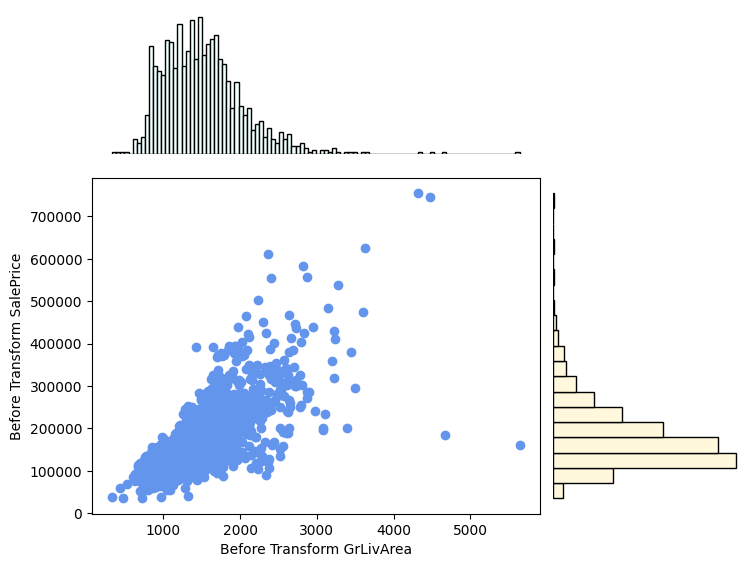

In [82]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(df['GrLivArea'], df['SalePrice'],color='cornflowerblue')
plt.xlabel("Before Transform GrLivArea")
plt.ylabel("Before Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

In [83]:
df['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

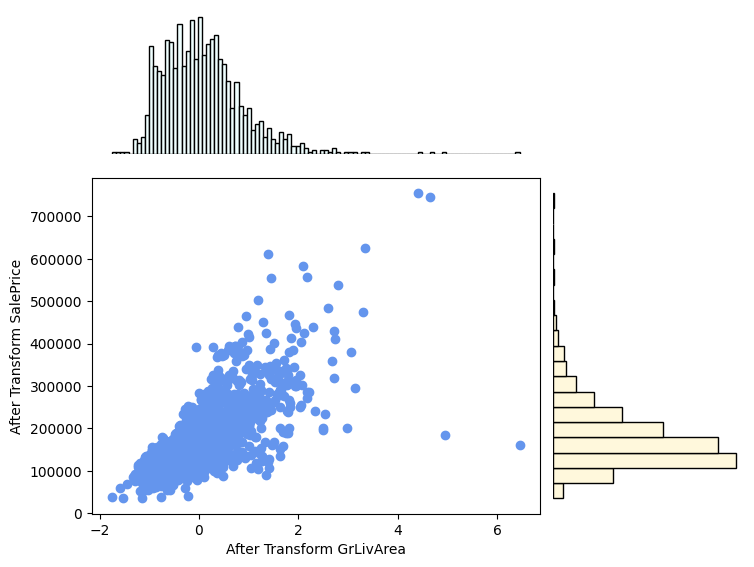

In [84]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(pro_df['GrLivArea'], pro_df['SalePrice'],color='cornflowerblue')
plt.xlabel("After Transform GrLivArea")
plt.ylabel("After Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(pro_df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(pro_df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

In [85]:
pro_df['GrLivArea'].describe()

count    1460.000000
mean        0.079511
std         0.811866
min        -1.745848
25%        -0.516802
50%         0.000000
75%         0.483198
max         6.455002
Name: GrLivArea, dtype: float64

In [ ]:
t_pro_df_tr,t_pro_df_tst=train_test_split(pro_df.sort_values(by=['YrSold','MoSold']),train_size=0.8,shuffle=False)
pro_df_tr,pro_df_tst=train_test_split(pro_df,train_size=0.8,shuffle=True)

Write dataframe into csv

In [ ]:
#pro_df_tr.to_csv('r_train.csv', index=False)
#pro_df_tst.to_csv('r_tst.csv', index=False)

Read dataframe from csv

In [ ]:
#pro_df_tr=pd.read_csv("r_train.csv")
#pro_df_tst=pd.read_csv("r_tst.csv")

In [340]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=pro_df_tr['SalePrice'],name='Train Data'))
fig.add_trace(go.Histogram(x=pro_df_tst['SalePrice'],name='Test Data'))

fig.update_layout(barmode='overlay',title="SalePrice Distribution after Train-Test Data Split")
fig.update_traces(opacity=0.75)

fig.show()

In [341]:
pro_df_tr

SalePrice  Street  CentralAir  MSZoning_C (all)  MSZoning_FV  \
1282     150500       1           1            0.0000       0.0000   
1086      83500       1           1            0.0000       0.0000   
592      138000       1           1            0.0000       0.0000   
611      148000       1           1            0.0000       0.0000   
111      180000       1           1            0.0000       0.0000   
...         ...     ...         ...               ...          ...   
1050     176485       1           1            0.0000       0.0000   
257      220000       1           1            0.0000       0.0000   
1029     118000       1           1            0.0000       0.0000   
432      122500       1           1            0.0000       0.0000   
356      173000       1           1            0.0000       0.0000   

      MSZoning_RH  MSZoning_RL  MSZoning_RM  Alley_Grvl  Alley_Pave  ...  \
1282       0.0000       1.0000       0.0000      0.0000      0.0000  ...   
1086       0.0000       0.0000       1.0000      0.0000      0.0000  ...   
592        0.0000       1.0000       0.0000      0.0000      0.0000  ...   
611        0.0000       1.0000       0.0000      0.0000      0.0000  ...   
111        0.0000       1.0000       0.0000      0.0000      0.0000  ...   
...           ...          ...          ...         ...         ...  ...   
1050       0.0000       1.0000       0.0000      0.0000      0.0000  ...   
257        0.0000       1.0000       0.0000      0.0000      0.0000  ...   
1029       0.0000       0.0000       1.0000      0.0000      0.0000  ...   
432        0.0000       0.0000       1.0000      0.0000      0.0000  ...   
356        0.0000       1.0000       0.0000      0.0000      0.0000  ...   

      PoolQC  BsmtExposure  BsmtFinType1  BsmtFinType2  Fence  LotFrontage  \
1282  0.0000        1.0000       -0.4000        2.0000 0.0000      -0.0541   
1086  0.0000        0.0000        0.0000        0.0000 0.0000      -1.7027   
592   0.0000        0.0000        0.4000        0.0000 0.0000      -0.0811   
611   0.0000        2.0000        0.2000        0.0000 3.0000      -1.7027   
111   0.0000        0.0000        0.4000        0.0000 0.0000      -1.7027   
...      ...           ...           ...           ...    ...          ...   
1050  0.0000        2.0000       -0.6000        0.0000 0.0000       0.2703   
257   0.0000        0.0000        0.4000        0.0000 0.0000       0.1351   
1029  0.0000        0.0000        0.0000        0.0000 0.0000      -1.1351   
432   0.0000        0.0000        0.2000        0.0000 0.0000      -1.0541   
356   0.0000        0.0000        0.4000        0.0000 0.0000      -1.7027   

      GarageYrBlt  MasVnrArea  estimated_garage_age(yr)  \
1282       0.0000      0.0000                    0.2024   
1086      -0.0930      0.0000                    0.3214   
592        0.1860      0.0000                   -0.0119   
611        0.0233      1.4186                    0.1310   
111        0.5349      0.0000                   -0.3214   
...           ...         ...                       ...   
1050       0.6977      0.0000                   -0.5595   
257        0.6744      1.0959                   -0.4881   
1029      -0.1163      1.7108                    0.2500   
432       -0.1395      2.2892                    0.2976   
356        0.3488      0.6454                   -0.1548   

      estimated_garage_age((month)  
1282                        0.2099  
1086                        0.3229  
592                        -0.0141  
611                         0.1332  
111                        -0.3330  
...                            ...  
1050                       -0.5671  
257                        -0.5045  
1029                        0.2503  
432                         0.3047  
356                        -0.1574  

[1168 rows x 262 columns]

In [92]:
pro_df_tst

SalePrice  Street  CentralAir  MSZoning_C (all)  MSZoning_FV  \
0       175500       1           1               0.0          0.0   
1        84500       1           1               0.0          0.0   
2        94750       1           1               0.0          0.0   
3       176000       1           1               0.0          1.0   
4       130000       1           1               0.0          0.0   
..         ...     ...         ...               ...          ...   
287     173000       1           1               0.0          0.0   
288     171500       1           1               0.0          0.0   
289      85000       1           0               1.0          0.0   
290     181500       1           1               0.0          0.0   
291      79900       1           1               0.0          0.0   

     MSZoning_RH  MSZoning_RL  MSZoning_RM  Alley_Grvl  Alley_Pave  ...  \
0            0.0          1.0          0.0         0.0         0.0  ...   
1            0.0          0.0          1.0         0.0         0.0  ...   
2            0.0          1.0          0.0         0.0         0.0  ...   
3            0.0          0.0          0.0         0.0         1.0  ...   
4            0.0          1.0          0.0         0.0         0.0  ...   
..           ...          ...          ...         ...         ...  ...   
287          0.0          1.0          0.0         0.0         0.0  ...   
288          0.0          1.0          0.0         0.0         0.0  ...   
289          0.0          0.0          0.0         0.0         0.0  ...   
290          0.0          1.0          0.0         0.0         0.0  ...   
291          0.0          0.0          1.0         0.0         0.0  ...   

     PoolQC  BsmtExposure  BsmtFinType1  BsmtFinType2  Fence  LotFrontage  \
0       0.0           0.0           0.4           1.0    4.0     0.405405   
1       0.0           2.0           0.0           5.0    3.0    -1.135135   
2       0.0           0.0          -0.2           0.0    0.0     0.270270   
3       0.0           0.0          -0.6           0.0    0.0    -0.027027   
4       0.0           0.0           0.2           0.0    3.0     0.054054   
..      ...           ...           ...           ...    ...          ...   
287     0.0           0.0           0.4           0.0    0.0    -0.135135   
288     0.0           0.0           0.2           1.0    3.0     0.324324   
289     0.0           0.0          -0.6           0.0    3.0     1.135135   
290     0.0           3.0           0.2           0.0    0.0     0.459459   
291     0.0           0.0          -0.6           0.0    3.0    -0.081081   

     GarageYrBlt  MasVnrArea  estimated_garage_age(yr)  \
0       0.093023    1.278539                  0.083333   
1     -45.976744    0.000000                 -0.559524   
2      -0.279070    0.292237                  0.440476   
3       0.651163    0.000000                 -0.535714   
4      -0.232558    0.541857                  0.440476   
..           ...         ...                       ...   
287     0.534884    0.000000                 -0.416667   
288     0.069767    0.000000                  0.107143   
289   -45.976744    0.000000                 -0.559524   
290    -0.023256    0.000000                  0.178571   
291   -45.976744    0.000000                 -0.559524   

     estimated_garage_age((month)  
0                        0.082745  
1                       -0.583249  
2                        0.443996  
3                       -0.550959  
4                        0.446014  
..                            ...  
287                     -0.433905  
288                      0.098890  
289                     -0.583249  
290                      0.177598  
291                     -0.583249  

[292 rows x 262 columns]

## **3. Model Selection**
### **Summary:**
10 common regression models are used for model screening before further optimization. Cross Validation (CV) is used during screening.
Gradient Boost Regression (GBR) is select since it achieves lowest RMSE during cross validation.


### **Section Highlights:**
1. 10 common regression models are used for model screening:
    1. Linear Regression
    2. Gradient Boost Regression
    3. Extra Boost Regression (XGR)
    4. Ridge
    5. LASSO
    6. LARS
    7. Decision Tree Regression
    8. Support Vector Regression
    9. Random Forest Regression
    10. LASSO LARS

2. 5-fold cross validation are used for model screening to prevent overfitting. Random Split is used, while Time-Based Split is used during model enhancement. 

3. RMSE is selected as the deciding performance metric. The smaller the RMSE, the smaller expected prediction error. RMSE criteria is depending on use case and is varied from industry to industry. For this project, the criteria of RMSE is set to be:
    1. Acceptable: less than 30% of Std of SalePrice in data set: RMSE<=$23,833
    2. Good: less than 10% of Std of SalePrice in data set: RMSE<=$7,944

4. GBR appears to be best model with lowest average RMSE ($29,982) and no significant high variation is found from CV bar chart.

In [94]:
def cv_reg(df,split_type):
    #initialize score
    tr_df=df.copy()

    LRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    GBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    XGBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RGscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    DTRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    SVRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RFRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSLARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }

    if split_type=='time':
        tr_df=tr_df.sort_values(by=['YrSold','MoSold'])
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            if i==0:
                b=a[i]
            #continue merging different data set and train
            if i>0:
                b=pd.concat([b,a[i]],axis=0)
            k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
            #assign validation set
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']
            val_x_=k_val.drop('SalePrice',axis=1)
            val_y_=k_val['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR(n_estimators=1000,learning_rate=0.01)
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR(n_estimators=1000,learning_rate=0.01)
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG(alpha=0.1)
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR(max_depth=5)
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR(C=100)
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR(n_estimators=1000,)
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
            
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    if split_type=='random':
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            b=a.copy()
            val_x_=b[i].drop('SalePrice',axis=1)
            val_y_=b[i]['SalePrice']
            del b[i]
            k_tr=pd.DataFrame()
            for j in range(len(b)):
                k_tr=pd.concat([k_tr,b[j]],axis=0)
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR(n_estimators=1000,learning_rate=0.01)
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR(n_estimators=1000,learning_rate=0.01)
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG(alpha=0.1)
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR(max_depth=5)
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR(C=100)
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR(n_estimators=1000,)
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
            
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    return pd.DataFrame(result)

In [95]:
def split_result(df):
    result1=pd.DataFrame()
    score_dict={}
    for c in df.columns:
        for i in df.index:
            model=[]
            score_list=[]
            for cv in range(0,len(df[df.columns[0]][0])):
                score_list.append(df[c][i][round(cv,4)])
                model.append(c)
            score_dict.update({'model':model,i:score_list})
            result2=pd.DataFrame(score_dict)
        #print(result2)
        #print(c)
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

In [96]:
def avg_summary(df):
    result1=pd.DataFrame()
    score_dict={}
    for m in df['model'].unique():
        for i in df.columns.drop('model'):
            score_dict.update({'model':m,i:sum(df.loc[df['model']==m][i])/len(df.loc[df['model']==m])})
        result2=pd.DataFrame(score_dict,index=[m])
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

Time-base Split CV Model Screening

In [ ]:
result=cv_reg(t_pro_df_tr,'time')

In [ ]:
screening=split_result(result)
print(avg_summary(screening).sort_values(by='RMSE',ascending=True))

In [ ]:
selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            #'Lasso',
            'DecisionTreeReg',
            'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            #'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

Summary of Random Split CV Model screening result shows that GradientBoot has the lowest average RMSE and good R2. The poor Adj_R2 indicates that most features used by all models do not improve the model predictions.

In [175]:
result=cv_reg(pro_df_tr,'random')

{'LinearReg': {'R2': [0.7890018721500099, 100, 100, 100, 100], 'RMSE': [34661.77029658888, 100, 100, 100, 100], 'Adj_R2': [2.755805849608846, 100, 100, 100, 100]}, 'GradientBoostReg': {'R2': [0.9040968653049571, 100, 100, 100, 100], 'RMSE': [23368.338788510337, 100, 100, 100, 100], 'Adj_R2': [1.7980510851408924, 100, 100, 100, 100]}, 'XGBReg': {'R2': [0.907240680993687, 100, 100, 100, 100], 'RMSE': [22982.12670757976, 100, 100, 100, 100], 'Adj_R2': [1.7718900474453898, 100, 100, 100, 100]}, 'Ridge': {'R2': [0.8133863802177619, 100, 100, 100, 100], 'RMSE': [32597.410939252208, 100, 100, 100, 100], 'Adj_R2': [2.552891907473624, 100, 100, 100, 100]}, 'Lasso': {'R2': [0.7998050601736757, 100, 100, 100, 100], 'RMSE': [33762.763519872926, 100, 100, 100, 100], 'Adj_R2': [2.6659078921261985, 100, 100, 100, 100]}, 'Lars': {'R2': [-2.173153095331901e+56, 100, 100, 100, 100], 'RMSE': [1.1123887814496488e+33, 100, 100, 100, 100], 'Adj_R2': [1.808373825758332e+57, 100, 100, 100, 100]}, 'DecisionTre

In [100]:
pd.options.display.float_format = '{:.4f}'.format

In [176]:
screening=split_result(result)
print(avg_summary(screening).sort_values(by='RMSE',ascending=True))

              model                                                 R2  \
1  GradientBoostReg                                             0.8518   
2            XGBReg                                             0.8503   
8   RandomForestReg                                             0.8380   
9         LassoLars                                             0.7653   
3             Ridge                                             0.7473   
4             Lasso                                             0.7284   
6   DecisionTreeReg                                             0.7128   
7  SupportVectorReg                                            -0.0569   
0         LinearReg                                  -67215792969.8415   
5              Lars -2232856967877114234835495828890261262461198471...   

                                     RMSE  \
1                              29981.6749   
2                              30119.5817   
8                              31532.4535   
9    

In [122]:
selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            'Lasso',
            'DecisionTreeReg',
            'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            #'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

## **4. Baseline Model Creation**
### **Summary:**
Baseline model (Model1) is created using Optuna hyperparameter optimization, achieve $26,585 RMSE validated with ***Test Dataset***

### **Section Highlights:**
A predefine hyperparameter range are setup for Optuna optimization. 5-fold random cross validation are used and Optuna is setup to maximize average balanced accuracy from cv. Optimized hyperparameter performance is measured using Test Dataset. It improves the balanced accuracy from $31,027 to $26,585.

In [383]:
def reg_result(model,val_x,val_y):
    pred_=model.predict(val_x)
    rmse_=root_mean_squared_error(val_y,pred_)
    r2_=r2_score(val_y,pred_)
    adj_r2_=1-(1-r2_)*(len(val_x)-1)/(len(val_x)-model.n_features_in_-1)

    print(f'RMSE:${round(rmse_):,} R2:%.4f Adj R2:%.4f'%(r2_,adj_r2_))

    fig = px.line(
        x=val_y,
        y=val_y,
        title='Predict vs Actual',
        )
    fig.add_trace(
        go.Scatter(x=val_y,y=pred_,mode='markers',name='Model Prediction')
    )
    fig.update_layout(
        xaxis_title="Actual House Price", 
        yaxis_title="Predicted House Price"
        )
    fig.update_layout()
    fig.show()

GradientBoostingRegressor

In [168]:
x_tr=pro_df_tr.drop('SalePrice',axis=1)
y_tr=pro_df_tr['SalePrice']
x_tst=pro_df_tst.drop('SalePrice',axis=1)
y_tst=pro_df_tst['SalePrice']

In [125]:
def opt_gbr_model(hpdict,train_x,train_y):

    GBRmodel=GBR(
        alpha=hpdict['alpha'],
        ccp_alpha=hpdict['ccp_alpha'],
        criterion=hpdict['criterion'],
        #init=hpdict['init'],
        learning_rate=hpdict['learning_rate'],
        loss=hpdict['loss'],
        max_depth=hpdict['max_depth'],
        #max_features=hpdict['max_features'],
        max_leaf_nodes=hpdict['max_leaf_nodes'],
        min_impurity_decrease=hpdict['min_impurity_decrease'],
        min_samples_leaf=hpdict['min_samples_leaf'],
        min_samples_split=hpdict['min_samples_split'],
        min_weight_fraction_leaf=hpdict['min_weight_fraction_leaf'],
        n_estimators=1000,
        #n_estimators=hpdict['n_estimators'],
        #n_iter_no_change=hpdict['n_iter_no_change'],
        random_state=1,
        #random_state=hpdict['random_state'],
        subsample=hpdict['subsample'],
        tol=hpdict['tol'],
        validation_fraction=hpdict['validation_fraction'],
        verbose=0,
        #warm_start=hpdict['warm_start']
        )

    GBRmodel.fit(train_x,train_y,)

    return GBRmodel

In [343]:
hp_example={
'alpha': 0.1,
'ccp_alpha': 0.1,
'criterion': 'friedman_mse',
#'init': None,
'learning_rate': 0.1,
'loss': 'squared_error',
'max_depth': 5,
#'max_features': None,
'max_leaf_nodes': 2,
'min_impurity_decrease': 5,
'min_samples_leaf': 1,
'min_samples_split': 2,
'min_weight_fraction_leaf': 0.1,
#'n_estimators': 1000,
#'n_iter_no_change': None,
#'random_state': None,
'subsample': 0.5,
'tol': 0.0001,
'validation_fraction': 0.1,
'verbose': 0,
#'warm_start': False,
}

In [344]:
Model0=opt_gbr_model(hp_example,x_tr,y_tr)
print('Train Data Result')
reg_result(Model0,x_tr,y_tr)
print('Test Data Result')
reg_result(Model0,x_tst,y_tst)

Train Data Result
RMSE:$26,967 R2:0.8843 Adj R2:0.8510


Test Data Result
RMSE:$31,027 R2:0.8494 Adj R2:-0.4605


In [128]:
def objective_random_cv_gbr(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,1000),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,0.3),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0,1000),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    'min_samples_split': trial.suggest_uniform('min_samples_split', 0.0001,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.001,1),
    'tol': trial.suggest_uniform('tol', 0.0,100),
    'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [178]:
study1 = optuna.create_study(direction="minimize")
study1.optimize(objective_random_cv_gbr, n_trials=100)
hp01=study1.best_params

[I 2024-07-09 12:29:31,854] A new study created in memory with name: no-name-aba7bd6e-8833-466c-8e9e-f3ce4a08d5e1
[I 2024-07-09 12:29:40,309] Trial 0 finished with value: 35683.0 and parameters: {'alpha': 0.7197705521553475, 'ccp_alpha': 339.61436895505403, 'criterion': 'squared_error', 'learning_rate': 0.03166151697437679, 'loss': 'squared_error', 'max_depth': 4, 'max_leaf_nodes': 6, 'min_impurity_decrease': 978.1856302389144, 'min_samples_leaf': 73, 'min_samples_split': 0.6560693651810412, 'min_weight_fraction_leaf': 0.07918889816182006, 'subsample': 0.7566354049738678, 'tol': 1.1252388559989557, 'validation_fraction': 0.051076558191896826}. Best is trial 0 with value: 35683.0.
[I 2024-07-09 12:29:42,059] Trial 1 finished with value: 96174.0 and parameters: {'alpha': 0.3202840960857005, 'ccp_alpha': 85.1668305308958, 'criterion': 'friedman_mse', 'learning_rate': 0.005744847115323082, 'loss': 'quantile', 'max_depth': 8, 'max_leaf_nodes': 33, 'min_impurity_decrease': 960.163754299731, 

In [183]:
hp01

{'alpha': 0.8920495137417662,
 'ccp_alpha': 5.038362168367598,
 'criterion': 'squared_error',
 'learning_rate': 0.02851927748423112,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_leaf_nodes': 8,
 'min_impurity_decrease': 690.4154880425946,
 'min_samples_leaf': 42,
 'min_samples_split': 0.6714514621676292,
 'min_weight_fraction_leaf': 0.018207781636879885,
 'subsample': 0.9440923416954748,
 'tol': 99.38849150564272,
 'validation_fraction': 0.20777691874862944}

Using Optuna, the hyperparameter is optimized and better RMSE result in Test data. However,
1. The Train data is extremely well and much better than Test data, this likely caused by overfitting. In the next optimization, 'loss':'squared_error' should be removed from optimization search space.
2. Adjusted R2 of Test Data is very poor, indicate that most features used are not helping model to explain the 'SalePrice' variation and should be removed.

In [345]:
Model1=opt_gbr_model(hp01,x_tr,y_tr)
print('Train Data Result')
reg_result(Model1,x_tr,y_tr)
print('Test Data Result')
reg_result(Model1,x_tst,y_tst)

Train Data Result
RMSE:$20,847 R2:0.9309 Adj R2:0.9109


Test Data Result
RMSE:$26,585 R2:0.8895 Adj R2:-0.0723


In [182]:
optuna.visualization.plot_param_importances(study1)

## **5. Feature Engineering and Model Tunning**
### **Summary:**
Least important features are removed and re-run Optuna hyperparmater optimization. Final model (model2) has improve RMSE from $26,585 to $25,367; however it does not meet RMSE criteria $23,833. Enhancement plan is setup to improve model performance through improving model generalization and explore Extra Gradient Boost Regression (XGBR).

### **Section Highlights:**
1. Less important features are remove in further optimization, final model has reduced features from 261 to 105.
2. Optuna hyperparameter optimization range is reduced to finetune efficiently.

In [201]:
def feat_importance(model):
    feat_df=pd.DataFrame(data={'Feature':model.feature_names_in_,'Importance':model.feature_importances_,})
    print('Total feature count is',len(feat_df['Feature']))

    #print('Top 20 Important Features')
    #display(feat_df.sort_values(by='Importance',ascending=False).head(20))

    fig = px.bar(feat_df.sort_values(by='Importance',ascending=True).tail(20),text_auto=True, y='Feature', x='Importance',orientation='h',title="Top 20 Feature Importance",height=1200)
    fig.show()

    fig = px.histogram(feat_df, x="Importance",histnorm='percent',nbins=5*len(feat_df),marginal='box',title="Feature Importance Distribution")
    fig.show()

    fig = px.ecdf(feat_df, x="Importance",marginal="histogram",title="Cumulative Distribution of Feature Importance")
    fig.show()

    return feat_df

In [202]:
model_feat1=feat_importance(Model1)

Total feature count is 261


In [203]:

#select feature based on importance values
def select_feat(model_feat,criteria):
    fe_to_select=model_feat[model_feat['Importance']>criteria]
    fe_to_remove=model_feat[model_feat['Importance']<=criteria]

    print(f'Total {len(fe_to_remove)} features to be removed based on criteria lower than',criteria)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on criteria higher than',criteria)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [204]:
#select feature by importance ranking
def select_feat2(model_feat,top):
    fe_to_select=model_feat.sort_values('Importance',ascending=False).head(top)
    fe_to_remove=model_feat.sort_values('Importance',ascending=False).tail(len(model_feat)-top)

    print(f'Total {len(fe_to_remove)} features to be removed based on ranking out of top',top)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on ranking of top',top)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [205]:
def update_feat(fe_to_remove,pro_df_tr_,tr_x_,tst_x_):
    fe_pro_df_tr_=pro_df_tr_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tr_x_=tr_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tst_x_=tst_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    return fe_pro_df_tr_,fe_tr_x_,fe_tst_x_

In [206]:
selected_feat,remove_feat=select_feat(model_feat1,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,pro_df_tr,x_tr,x_tst)

Total 191 features to be removed based on criteria lower than 0


Feature  Importance
0                      Street      0.0000
152           Functional_Min1      0.0000
143              Heating_Wall      0.0000
144          Electrical_FuseA      0.0000
145          Electrical_FuseF      0.0000
..                        ...         ...
83             RoofStyle_Flat      0.0000
84            RoofStyle_Gable      0.0000
85          RoofStyle_Gambrel      0.0000
86              RoofStyle_Hip      0.0000
259  estimated_garage_age(yr)      0.0000

[191 rows x 2 columns]

Total 70 features to be retained based on criteria higher than 0


Feature  Importance
207           OverallQual      0.4422
218             GrLivArea      0.1500
227            GarageCars      0.1018
211            BsmtFinSF1      0.0421
214           TotalBsmtSF      0.0405
..                    ...         ...
36   Neighborhood_Gilbert      0.0000
40     Neighborhood_NAmes      0.0000
162     GarageType_Detchd      0.0000
237                YrSold      0.0000
130      MasVnrType_Stone      0.0000

[70 rows x 2 columns]

In [ ]:
#selected_feat,remove_feat=select_feat2(model_feat1,261)

After filter out zero importance features, significant improvement of Adjusted R2 in Test Data is obtained.

In [207]:
Model1=opt_gbr_model(hp01,fe_x_tr,y_tr)
print('Train Data Result')
reg_result(Model1,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model1,fe_x_tst,y_tst)

Train Data Result
RMSE:$20,847 R2:0.9309 Adj R2:0.9264


Test Data Result
RMSE:$26,585 R2:0.8895 Adj R2:0.8544


New objective_random_cv_gbr_fe function will use selected features and previous hyperparameter for optimization. Also it removes 'squared_error' from 'loss' hyperparameter search space to reduce overfiting into Train Data.

In [210]:
def objective_random_cv_gbr_fe(trial):
   
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['absolute_error','huber','quantile','squared_error']#,
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-100),min(hp_optuna['ccp_alpha']+100,1000)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',max(2,hp_optuna["max_leaf_nodes"]-5),min(hp_optuna["max_leaf_nodes"]+5,100)),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-100),min(hp_optuna['min_impurity_decrease']+100,1000)),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',max(1,hp_optuna["min_samples_leaf"]-10),min(hp_optuna["min_samples_leaf"]+10,100)),
    'min_samples_split': trial.suggest_uniform('min_samples_split',max(0,hp_optuna["min_samples_split"]-0.1),min(hp_optuna["min_samples_split"]+0.1,1)),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,0.5)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,1)),
    'tol': trial.suggest_uniform('tol',max(0,hp_optuna['tol']-10),min(hp_optuna['tol']+10,100)),
    'validation_fraction': trial.suggest_uniform('validation_fraction',max(0,hp_optuna['validation_fraction']-0.1),min(hp_optuna['validation_fraction']+0.1,1)),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)


    return best_score

In [211]:
#pass hp01 as default parameter for optimization in objective_random_cv_gbr_fe
hp_optuna=hp01

study2 = optuna.create_study(direction="minimize")
study2.optimize(objective_random_cv_gbr_fe, n_trials=100)
hp02=study2.best_params

[I 2024-07-09 13:16:10,686] A new study created in memory with name: no-name-ebc24cab-a54d-406c-8355-191b10d34b36
[I 2024-07-09 13:16:17,084] Trial 0 finished with value: 81046.8 and parameters: {'alpha': 0.8760739924779637, 'ccp_alpha': 84.25683030172974, 'criterion': 'squared_error', 'learning_rate': 0.09890631958620152, 'loss': 'absolute_error', 'max_depth': 7, 'max_leaf_nodes': 9, 'min_impurity_decrease': 602.9870459188073, 'min_samples_leaf': 50, 'min_samples_split': 0.7459928313609423, 'min_weight_fraction_leaf': 0.09541912071225676, 'subsample': 0.9610308728218989, 'tol': 90.29553270652605, 'validation_fraction': 0.22849621737142256}. Best is trial 0 with value: 81046.8.
[I 2024-07-09 13:16:23,157] Trial 1 finished with value: 80917.6 and parameters: {'alpha': 0.9255147538429292, 'ccp_alpha': 21.250495084137604, 'criterion': 'friedman_mse', 'learning_rate': 0.0938012552614089, 'loss': 'absolute_error', 'max_depth': 7, 'max_leaf_nodes': 5, 'min_impurity_decrease': 650.85301968049

In [212]:
hp02

{'alpha': 0.9255961785026856,
 'ccp_alpha': 91.41840526743391,
 'criterion': 'squared_error',
 'learning_rate': 0.08954087410410139,
 'loss': 'huber',
 'max_depth': 3,
 'max_leaf_nodes': 13,
 'min_impurity_decrease': 696.0681036379524,
 'min_samples_leaf': 35,
 'min_samples_split': 0.6231724861087317,
 'min_weight_fraction_leaf': 0.01911842431225484,
 'subsample': 0.8744747724971967,
 'tol': 93.81456919882424,
 'validation_fraction': 0.24390880714068283}

Model2 Train Data RMSE is poorer than Model1, but better RMSE in Test Data, and the performance difference between the two data sets are smaller, indicate that Model2 is a more generalized model and less overfitting.

In [213]:
Model2=opt_gbr_model(hp02,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(Model2,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model2,fe_x_tst,y_tst)

Training Data Result
RMSE:$21,532 R2:0.9262 Adj R2:0.9215


Test Data Result
RMSE:$25,367 R2:0.8994 Adj R2:0.8675


From hyperparameter importance, since 'loss' is the most critical parameter, we will fix 'loss' hyperparameter and try to optimize others.

In [214]:
optuna.visualization.plot_param_importances(study2)

In [215]:
def objective_random_cv_gbr_fe2(trial):
   
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['absolute_error','huber','quantile']#'squared_error',
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-100),min(hp_optuna['ccp_alpha']+100,1000)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss':'huber',
    #'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',max(2,hp_optuna["max_leaf_nodes"]-5),min(hp_optuna["max_leaf_nodes"]+5,100)),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-100),min(hp_optuna['min_impurity_decrease']+100,1000)),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',max(1,hp_optuna["min_samples_leaf"]-10),min(hp_optuna["min_samples_leaf"]+10,100)),
    'min_samples_split': trial.suggest_uniform('min_samples_split',max(0,hp_optuna["min_samples_split"]-0.1),min(hp_optuna["min_samples_split"]+0.1,1)),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,0.5)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,1)),
    'tol': trial.suggest_uniform('tol',max(0,hp_optuna['tol']-10),min(hp_optuna['tol']+10,100)),
    'validation_fraction': trial.suggest_uniform('validation_fraction',max(0,hp_optuna['validation_fraction']-0.1),min(hp_optuna['validation_fraction']+0.1,1)),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)


    return best_score

In [216]:
model_feat2=feat_importance(Model2)
selected_feat,remove_feat=select_feat(model_feat2,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,fe_pro_df_tr,fe_x_tr,fe_x_tst)

Total feature count is 70


Total 3 features to be removed based on criteria lower than 0


Feature  Importance
17   Exterior1st_CemntBd      0.0000
18   Exterior1st_Plywood      0.0000
26  SaleCondition_Normal      0.0000

Total 67 features to be retained based on criteria higher than 0


Feature  Importance
31          OverallQual      0.4307
41            GrLivArea      0.1756
38          TotalBsmtSF      0.0613
47           GarageCars      0.0520
35           BsmtFinSF1      0.0301
..                  ...         ...
20     MasVnrType_Stone      0.0000
19  Exterior2nd_CmentBd      0.0000
53               YrSold      0.0000
28        MSSubClass_50      0.0000
12  Neighborhood_NWAmes      0.0000

[67 rows x 2 columns]

In [217]:
Model2=opt_gbr_model(hp02,fe_x_tr,y_tr)
print('Train Data Result')
reg_result(Model2,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model2,fe_x_tst,y_tst)

Train Data Result
RMSE:$21,532 R2:0.9262 Adj R2:0.9217


Test Data Result
RMSE:$25,365 R2:0.8994 Adj R2:0.8693


In [218]:
hp_optuna=hp02

study3 = optuna.create_study(direction="minimize")
study3.optimize(objective_random_cv_gbr_fe2, n_trials=100)
hp03=study3.best_params

[I 2024-07-09 13:35:43,686] A new study created in memory with name: no-name-07116df2-72de-438e-b7d4-f2c557264203
[I 2024-07-09 13:35:53,420] Trial 0 finished with value: 32195.6 and parameters: {'alpha': 0.8562144265612678, 'ccp_alpha': 132.640366005783, 'criterion': 'squared_error', 'learning_rate': 0.05386481546826665, 'max_depth': 6, 'max_leaf_nodes': 9, 'min_impurity_decrease': 775.8100165883668, 'min_samples_leaf': 40, 'min_samples_split': 0.7119850820136171, 'min_weight_fraction_leaf': 0.09873514456540453, 'subsample': 0.9019581600542703, 'tol': 94.6972764025619, 'validation_fraction': 0.14502260773858394}. Best is trial 0 with value: 32195.6.
[I 2024-07-09 13:36:00,869] Trial 1 finished with value: 29651.4 and parameters: {'alpha': 0.8765749341639295, 'ccp_alpha': 138.15928856367353, 'criterion': 'squared_error', 'learning_rate': 0.05437911255745406, 'max_depth': 1, 'max_leaf_nodes': 9, 'min_impurity_decrease': 644.8240754434585, 'min_samples_leaf': 36, 'min_samples_split': 0.5

In [219]:
hp03

{'alpha': 0.8661996149009993,
 'ccp_alpha': 165.32869341848289,
 'criterion': 'squared_error',
 'learning_rate': 0.08526569497923867,
 'max_depth': 5,
 'max_leaf_nodes': 15,
 'min_impurity_decrease': 691.6427599753308,
 'min_samples_leaf': 28,
 'min_samples_split': 0.5896783591512803,
 'min_weight_fraction_leaf': 0.02903829938678832,
 'subsample': 0.9482330115410103,
 'tol': 91.79677884854289,
 'validation_fraction': 0.258543436313661}

In [220]:
hp03.update({'loss':'huber'})

In [221]:
Model3=opt_gbr_model(hp03,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(Model3,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(Model3,fe_x_tst,y_tst)

Training Data Result
RMSE:$21,012 R2:0.9298 Adj R2:0.9255


Test Data Result
RMSE:$25,896 R2:0.8951 Adj R2:0.8637


In [222]:
optuna.visualization.plot_param_importances(study3)

In [223]:
model_feat3=feat_importance(Model3)

Total feature count is 67


## **6. Model Enhancement**
### **Summary:**
Typical model enhancement is to revisit model training workflow, such as improve data cleaning, feature engineering and explore new model. Based on past experience, the model performance might be improved by improve model generalization and swtich to other model.

The final model has achieved RMSE $22,536 which meet the RMSE criteria. The enhancements include:
1. Use Time-Based Train-Test Data Split instead of Random Train-Test Data Split: Time-Based Split focuses on  improve model performance stability during machine learning.
2. Reduce features: Typically model which uses less features will be more generalized than model uses more features.
3. Switch to XGBR. XGBR is the 2nd rank model during model screening.

### **Section Highlights:**
1. Time-Based Split GBR: Time-Based Split can be thought as Backtesting with continuous rolling time period data:
    1. During model training or cross validation, the data is split according the time periods (eg: 5 time periods).
    2. During cross validation, the first time period (T=1) data is split in to 80/20 for train-test according to time. When move into next time period (T=2), combined both time period data and split into 80/20 according to time again forr train-test, and so on. Machine learning with good cross validation results will indicate good time stability of model performance

![alt text](Assets/time_based_split_illustration.jpg)

2. Random Split XGBR has achieved even better RMSE $22,456, however there might be overfitting since the train data RMSE is extremely well $8,493.
3. Feature is reduced and stop when Adj R2 is not improving.

### Time-base Split GBR

In [224]:
t_pro_df_tr,t_pro_df_tst=train_test_split(pro_df.sort_values(by=['YrSold','MoSold']),train_size=0.8,shuffle=False)

In [225]:
t_pro_df_tr.to_csv('t_train.csv', index=False)
t_pro_df_tst.to_csv('t_tst.csv', index=False)

Distribution of Train-Test data using Time-Based Split

In [226]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=t_pro_df_tr['SalePrice'],name='Train Data'))
fig.add_trace(go.Histogram(x=t_pro_df_tst['SalePrice'],name='Test Data'))

fig.update_layout(barmode='overlay',title="SalePrice Distribution after Train-Test Data Time-Based Split")
fig.update_traces(opacity=0.75)

fig.show()

Time-base Split CV Model Screening

Summary of Time-Based Split CV Model screening result shows that GradientBoot has the lowest average RMSE and good R2. The poor Adj_R2 indicates that most features used by all models do not improve the model predictions.

In [233]:
result=cv_reg(t_pro_df_tr,'time')

{'LinearReg': {'R2': [-18.14988202558152, 100, 100, 100, 100], 'RMSE': [400578.07392871147, 100, 100, 100, 100], 'Adj_R2': [5.097184061287209, 100, 100, 100, 100]}, 'GradientBoostReg': {'R2': [0.929144435814218, 100, 100, 100, 100], 'RMSE': [24366.385049017164, 100, 100, 100, 100], 'Adj_R2': [1.0151597951281208, 100, 100, 100, 100]}, 'XGBReg': {'R2': [0.9043562221304413, 100, 100, 100, 100], 'RMSE': [28309.518560884928, 100, 100, 100, 100], 'Adj_R2': [1.0204633199162776, 100, 100, 100, 100]}, 'Ridge': {'R2': [0.7551905127170164, 100, 100, 100, 100], 'RMSE': [45291.66066203976, 100, 100, 100, 100], 'Adj_R2': [1.0523778437907778, 100, 100, 100, 100]}, 'Lasso': {'R2': [-0.0776239597708197, 100, 100, 100, 100], 'RMSE': [95024.9701975852, 100, 100, 100, 100], 'Adj_R2': [1.230561405346315, 100, 100, 100, 100]}, 'Lars': {'R2': [-4.570824785431145e+60, 100, 100, 100, 100], 'RMSE': [1.957047692942282e+35, 100, 100, 100, 100], 'Adj_R2': [9.77943907580617e+59, 100, 100, 100, 100]}, 'DecisionTreeR

In [237]:
screening=split_result(result)
print(avg_summary(screening).sort_values(by='RMSE',ascending=True))

selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            'Lasso',
            'DecisionTreeReg',
            'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            #'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

              model                                                 R2  \
1  GradientBoostReg                                             0.7776   
8   RandomForestReg                                             0.7992   
2            XGBReg                                             0.7211   
9         LassoLars                                             0.6364   
3             Ridge                                             0.6099   
6   DecisionTreeReg                                             0.5649   
4             Lasso                                             0.4302   
7  SupportVectorReg                                            -0.0495   
0         LinearReg                               -54994157079563.9609   
5              Lars -8612162792692711266904705753855066641456108176...   

                                              RMSE  \
1                                       33242.0244   
8                                       33375.6424   
2                      

In [238]:
t_x_tr=t_pro_df_tr.drop('SalePrice',axis=1)
t_y_tr=t_pro_df_tr['SalePrice']
t_x_tst=t_pro_df_tst.drop('SalePrice',axis=1)
t_y_tst=t_pro_df_tst['SalePrice']

In [240]:
Model0=opt_gbr_model(hp_example,t_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Model0,t_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Model0,t_x_tst,t_y_tst)

Train Data Result
RMSE:$27,545 R2:0.8819 Adj R2:0.8479


Test Data Result
RMSE:$27,357 R2:0.8705 Adj R2:-0.2561


In [243]:
def objective_time_cv_gbr(trial):
   
    tr_df=t_pro_df_tr.sort_values(by=['YrSold','MoSold']).copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,1000),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,0.3),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0,1000),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    'min_samples_split': trial.suggest_uniform('min_samples_split', 0.0001,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.001,1),
    'tol': trial.suggest_uniform('tol', 0.0,100),
    'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        if i==0:
            b=a[i].copy()
        if i>0:
            b=pd.concat([b,a[i]],axis=0)

        k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']
        val_x_=k_val.drop('SalePrice',axis=1)
        val_y_=k_val['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        #r2_=r2_score(val_y_,pred_)
        #adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [244]:
studyt1 = optuna.create_study(direction="minimize")
studyt1.optimize(objective_time_cv_gbr, n_trials=100)
hpt01=studyt1.best_params

[I 2024-07-09 14:23:52,798] A new study created in memory with name: no-name-60d6d837-7a29-4bb4-8542-59b36d9bccc3
[I 2024-07-09 14:23:57,631] Trial 0 finished with value: 83522.6 and parameters: {'alpha': 0.10157831660861438, 'ccp_alpha': 967.9107024744219, 'criterion': 'friedman_mse', 'learning_rate': 0.2759429646660061, 'loss': 'absolute_error', 'max_depth': 12, 'max_leaf_nodes': 91, 'min_impurity_decrease': 458.3427245862518, 'min_samples_leaf': 91, 'min_samples_split': 0.7305092382886323, 'min_weight_fraction_leaf': 0.3399226537632309, 'subsample': 0.8135738741122461, 'tol': 53.602241074197764, 'validation_fraction': 0.06452043387164863}. Best is trial 0 with value: 83522.6.
[I 2024-07-09 14:23:59,247] Trial 1 finished with value: 84301.8 and parameters: {'alpha': 0.3403264965545578, 'ccp_alpha': 983.9466811869503, 'criterion': 'friedman_mse', 'learning_rate': 0.03149684530483756, 'loss': 'absolute_error', 'max_depth': 10, 'max_leaf_nodes': 78, 'min_impurity_decrease': 874.30506698

In [245]:
hpt01

{'alpha': 0.40118799751244255,
 'ccp_alpha': 474.83337181909627,
 'criterion': 'squared_error',
 'learning_rate': 0.11166137432664,
 'loss': 'huber',
 'max_depth': 2,
 'max_leaf_nodes': 68,
 'min_impurity_decrease': 774.1013153235639,
 'min_samples_leaf': 4,
 'min_samples_split': 0.5133865200424803,
 'min_weight_fraction_leaf': 0.024732997221446333,
 'subsample': 0.6908015860891121,
 'tol': 72.24587702460241,
 'validation_fraction': 0.21948171015742818}

In [306]:
modelt1=opt_gbr_model(hpt01,t_x_tr,t_y_tr)
print('Train Data Result')
reg_result(modelt1,t_x_tr,t_y_tr)
print('Test Data Result')
reg_result(modelt1,t_x_tst,t_y_tst)

Train Data Result
RMSE:$24,190 R2:0.9089 Adj R2:0.8827


Test Data Result
RMSE:$22,948 R2:0.9089 Adj R2:0.1162


In [277]:
model_feat1=feat_importance(modelt1)

Total feature count is 261


Reduce feature based on low importance value, until Adj R2 is not improving.

In [300]:
selected_feat,remove_feat=select_feat(model_feat1,0.0006)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,t_pro_df_tr,t_x_tr,t_x_tst)

Total 208 features to be removed based on criteria lower than 0.0006


Feature  Importance
209             YearBuilt      0.0005
48   Neighborhood_SawyerW      0.0005
51    Neighborhood_Timber      0.0005
40     Neighborhood_NAmes      0.0005
35   Neighborhood_Edwards      0.0005
..                    ...         ...
98    Exterior1st_AsphShn      0.0000
99    Exterior1st_BrkComm      0.0000
101    Exterior1st_CBlock      0.0000
102   Exterior1st_CemntBd      0.0000
116    Exterior2nd_CBlock      0.0000

[208 rows x 2 columns]

Total 53 features to be retained based on criteria higher than 0.0006


Feature  Importance
207                    OverallQual      0.3042
218                      GrLivArea      0.2394
238     estimated_house_age(month)      0.0711
214                    TotalBsmtSF      0.0521
247                    KitchenQual      0.0415
215                       1stFlrSF      0.0341
242                      ExterQual      0.0323
228                     GarageArea      0.0295
211                     BsmtFinSF1      0.0251
206                        LotArea      0.0227
248                    FireplaceQu      0.0198
227                     GarageCars      0.0197
208                    OverallCond      0.0119
244                       BsmtQual      0.0094
6                      MSZoning_RM      0.0073
241  estimated_remodadd_age(month)      0.0050
229                     WoodDeckSF      0.0048
253                   BsmtFinType1      0.0044
210                   YearRemodAdd      0.0043
213                      BsmtUnfSF      0.0038
256                    LotFrontage      0.0029
252                   BsmtExposure      0.0028
257                    GarageYrBlt      0.0024
216                       2ndFlrSF      0.0022
100            Exterior1st_BrkFace      0.0021
1                       CentralAir      0.0021
230                    OpenPorchSF      0.0019
258                     MasVnrArea      0.0018
226                     Fireplaces      0.0018
196                  MSSubClass_60      0.0017
156                 Functional_Typ      0.0015
53               Condition1_Artery      0.0014
182                   SaleType_New      0.0014
55                 Condition1_Norm      0.0014
236                         MoSold      0.0013
249                     GarageQual      0.0013
192                  MSSubClass_30      0.0013
31            Neighborhood_BrkSide      0.0012
34            Neighborhood_Crawfor      0.0012
21               LotConfig_CulDSac      0.0011
224                   KitchenAbvGr      0.0010
212                     BsmtFinSF2      0.0010
260   estimated_garage_age((month)      0.0010
233                    ScreenPorch      0.0010
250                     GarageCond      0.0009
222                       HalfBath      0.0009
170                   PavedDrive_Y      0.0008
231                  EnclosedPorch      0.0008
45            Neighborhood_OldTown      0.0007
44            Neighborhood_NridgHt      0.0007
43            Neighborhood_NoRidge      0.0007
49            Neighborhood_Somerst      0.0006
185          SaleCondition_Abnorml      0.0006

In [301]:
Modelt1=opt_gbr_model(hpt01,fe_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Modelt1,fe_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Modelt1,fe_x_tst,t_y_tst)

Train Data Result
RMSE:$24,517 R2:0.9064 Adj R2:0.9020


Test Data Result
RMSE:$22,711 R2:0.9108 Adj R2:0.8909


In [302]:
def objective_time_cv_gbr_fe(trial):
   
    tr_df=t_pro_df_tr.sort_values(by=['YrSold','MoSold']).copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['absolute_error','huber','quantile','squared_error']#,
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-100),min(hp_optuna['ccp_alpha']+100,1000)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',max(2,hp_optuna["max_leaf_nodes"]-5),min(hp_optuna["max_leaf_nodes"]+5,100)),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-100),min(hp_optuna['min_impurity_decrease']+100,1000)),
    'min_samples_leaf':trial.suggest_int('min_samples_leaf',max(1,hp_optuna["min_samples_leaf"]-10),min(hp_optuna["min_samples_leaf"]+10,100)),
    'min_samples_split': trial.suggest_uniform('min_samples_split',max(0,hp_optuna["min_samples_split"]-0.1),min(hp_optuna["min_samples_split"]+0.1,1)),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,0.5)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,1)),
    'tol': trial.suggest_uniform('tol',max(0,hp_optuna['tol']-10),min(hp_optuna['tol']+10,100)),
    'validation_fraction': trial.suggest_uniform('validation_fraction',max(0,hp_optuna['validation_fraction']-0.1),min(hp_optuna['validation_fraction']+0.1,1)),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        if i==0:
            b=a[i].copy()
        if i>0:
            b=pd.concat([b,a[i]],axis=0)

        k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']
        val_x_=k_val.drop('SalePrice',axis=1)
        val_y_=k_val['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        #r2_=r2_score(val_y_,pred_)
        #adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [303]:
hp_optuna=hpt01

studyt2 = optuna.create_study(direction="minimize")
studyt2.optimize(objective_time_cv_gbr_fe, n_trials=100)
hpt02=studyt2.best_params

[I 2024-07-09 15:57:03,203] A new study created in memory with name: no-name-ed697c7d-e178-4fac-bb48-b04739816035
[I 2024-07-09 15:57:08,388] Trial 0 finished with value: 83420.4 and parameters: {'alpha': 0.4390659425152682, 'ccp_alpha': 409.41021199269704, 'criterion': 'friedman_mse', 'learning_rate': 0.026153772723991987, 'loss': 'absolute_error', 'max_depth': 7, 'max_leaf_nodes': 68, 'min_impurity_decrease': 789.5491025077911, 'min_samples_leaf': 7, 'min_samples_split': 0.41979003212363586, 'min_weight_fraction_leaf': 0.01723253000228546, 'subsample': 0.7546511262952431, 'tol': 80.87723809082367, 'validation_fraction': 0.2100509160885221}. Best is trial 0 with value: 83420.4.
[I 2024-07-09 15:57:13,416] Trial 1 finished with value: 85849.0 and parameters: {'alpha': 0.44735705112861524, 'ccp_alpha': 540.3850530777563, 'criterion': 'friedman_mse', 'learning_rate': 0.1504596363130631, 'loss': 'quantile', 'max_depth': 2, 'max_leaf_nodes': 64, 'min_impurity_decrease': 781.0092792289606, 

In [304]:
hpt02

{'alpha': 0.42012310698145466,
 'ccp_alpha': 552.5947662187496,
 'criterion': 'friedman_mse',
 'learning_rate': 0.10582277980427916,
 'loss': 'huber',
 'max_depth': 2,
 'max_leaf_nodes': 71,
 'min_impurity_decrease': 704.573529132188,
 'min_samples_leaf': 5,
 'min_samples_split': 0.46604626715519853,
 'min_weight_fraction_leaf': 0.024589971127706854,
 'subsample': 0.7151334413727816,
 'tol': 63.682813582561245,
 'validation_fraction': 0.2860572681865936}

Stop finetune since RMSE has not improvement.

In [305]:
Modelt2=opt_gbr_model(hpt02,fe_x_tr,t_y_tr)
print('Training Data Result')
reg_result(Modelt2,fe_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Modelt2,fe_x_tst,t_y_tst)

Training Data Result
RMSE:$24,142 R2:0.9093 Adj R2:0.9050


Test Data Result
RMSE:$22,671 R2:0.9111 Adj R2:0.8913


In [613]:
model_feat1=feat_importance(Modelt2)

Total feature count is 53


### Random Split XGBR

In [771]:
#Fit model with parameter dict and space
def opt_xgb_reg(hpdict,x_tr_,y_tr_):

    xgb_model=XGBR(
        max_depth=int(hpdict['max_depth']),
        max_leaves=int(hpdict['max_leaves']),
        grow_policy=hpdict['grow_policy'],
        learning_rate=hpdict['learning_rate'],
        objective=hpdict['objective'],
        gamma=hpdict['gamma'],
        max_delta_step=int(hpdict['max_delta_step']),
        subsample=hpdict['subsample'],
        reg_alpha=hpdict['reg_alpha'],
        reg_lambda=hpdict['reg_lambda'],
        colsample_bytree=hpdict['colsample_bytree'],     
        min_child_weight=hpdict['min_child_weight'],
        importance_type=hpdict['importance_type'],

        booster='gbtree',        
        tree_method='hist',    
        n_estimators=1000,
        #device='cuda',
        #sampling_method='gradient_based'
        )

    xgb_model.fit(
        x_tr_,
        y_tr_,
        verbose=False
        )

    return xgb_model

In [609]:
hp_example={
    'max_depth': 10,
    'max_leaves':5,
    'grow_policy':'lossguide',
    'objective':'reg:absoluteerror',
    'learning_rate':0.01,
    'gamma': 2,
    'max_delta_step':2,
    'subsample': 0.2,
    'reg_alpha': 2,
    'reg_lambda': 2,
    'colsample_bytree':0.2,
    'min_child_weight':0.2,
    'importance_type':'gain',
}

In [610]:
xbgr0=opt_xgb_reg(hp_example,x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr0,x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr0,x_tst,y_tst)

Training Data Result
RMSE:$29,006 R2:0.8661 Adj R2:0.8276


Test Data Result
RMSE:$30,606 R2:0.8535 Adj R2:-0.4212


In [668]:
def objective_random_cv_xgbr(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    #XGB cat type hyperparameters setup
    hp_objective=['reg:squarederror','reg:absoluteerror'] #'reg:squaredlogerror', (taking too long to run if set to 'reg:squaredlogerror')
    hp_grow_policy=['depthwise','lossguide']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    hp_booster=['gbtree','dart']

    xgb_optuna_hpdict={
        'max_depth': trial.suggest_int("max_depth", 6, 18),
        'max_leaves':trial.suggest_int("max_leaves", 0, 10),
        'grow_policy':trial.suggest_categorical('grow_policy',hp_grow_policy),
        'learning_rate':trial.suggest_uniform('learning_rate', 0,1),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'gamma': trial.suggest_uniform('gamma', 0,10),
        'max_delta_step':trial.suggest_int("max_delta_step", 0, 10),
        'subsample':trial.suggest_uniform('subsample', 0,1),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', 0,10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', 0,10),
        'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0,1),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'booster':trial.suggest_categorical('booster',hp_booster), slow to run for dart
        }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_xgb_reg(xgb_optuna_hpdict,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [612]:
studyx1= optuna.create_study(direction="minimize")
studyx1.optimize(objective_random_cv_xgbr, n_trials=100)
hp_optuna = studyx1.best_params
hpx01=studyx1.best_params

[I 2024-07-10 14:36:39,059] A new study created in memory with name: no-name-cdc4b76b-b0d8-43a9-bfb3-985df1273129
[I 2024-07-10 14:36:49,433] Trial 0 finished with value: 51911.6 and parameters: {'max_depth': 17, 'max_leaves': 9, 'grow_policy': 'depthwise', 'learning_rate': 0.5694200424591666, 'objective': 'reg:squarederror', 'gamma': 1.9313033329328488, 'max_delta_step': 8, 'subsample': 0.21031118537970117, 'reg_alpha': 5.423175862220154, 'reg_lambda': 8.094104014236787, 'colsample_bytree': 0.2083149758174987, 'min_child_weight': 0.14188965320421876, 'importance_type': 'gain'}. Best is trial 0 with value: 51911.6.
[I 2024-07-10 14:36:59,573] Trial 1 finished with value: 36340.8 and parameters: {'max_depth': 12, 'max_leaves': 5, 'grow_policy': 'lossguide', 'learning_rate': 0.715414377682087, 'objective': 'reg:absoluteerror', 'gamma': 8.227619394529162, 'max_delta_step': 1, 'subsample': 0.6635741207672031, 'reg_alpha': 1.2171158813587346, 'reg_lambda': 5.008993018568209, 'colsample_bytr

In [650]:
hpx01

{'max_depth': 8,
 'max_leaves': 10,
 'grow_policy': 'lossguide',
 'learning_rate': 0.03925883548628113,
 'objective': 'reg:squarederror',
 'gamma': 8.27104006270885,
 'max_delta_step': 9,
 'subsample': 0.6586430919437203,
 'reg_alpha': 0.43144688423870603,
 'reg_lambda': 6.766666372395109,
 'colsample_bytree': 0.49012348377360987,
 'min_child_weight': 0.25882103871566897,
 'importance_type': 'total_gain'}

In [683]:
xbgr1=opt_xgb_reg(hpx01,x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr1,x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr1,x_tst,y_tst)

Training Data Result
RMSE:$5,445 R2:0.9953 Adj R2:0.9939


Test Data Result
RMSE:$22,686 R2:0.9195 Adj R2:0.2192


In [684]:
model_feat1=feat_importance(xbgr1)

Total feature count is 261


In [755]:
selected_feat,remove_feat=select_feat(model_feat1,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,pro_df_tr,x_tr,x_tst)

Total 68 features to be removed based on criteria lower than 0


Feature  Importance
0                 Street      0.0000
142         Heating_OthW      0.0000
155       Functional_Sev      0.0000
149       Electrical_nan      0.0000
147       Electrical_Mix      0.0000
..                   ...         ...
99   Exterior1st_BrkComm      0.0000
101   Exterior1st_CBlock      0.0000
104  Exterior1st_ImStucc      0.0000
107    Exterior1st_Stone      0.0000
204       MSSubClass_180      0.0000

[68 rows x 2 columns]

Total 193 features to be retained based on criteria higher than 0


Feature  Importance
207           OverallQual      0.3267
218             GrLivArea      0.1290
227            GarageCars      0.0950
242             ExterQual      0.0551
214           TotalBsmtSF      0.0408
..                    ...         ...
112   Exterior2nd_AsbShng      0.0000
38   Neighborhood_MeadowV      0.0000
73         BldgType_Twnhs      0.0000
88         RoofStyle_Shed      0.0000
81      HouseStyle_SFoyer      0.0000

[193 rows x 2 columns]

In [686]:
xbgr1_1=opt_xgb_reg(hpx01,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr1_1,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr1_1,fe_x_tst,y_tst)

Training Data Result
RMSE:$5,534 R2:0.9951 Adj R2:0.9942


Test Data Result
RMSE:$22,675 R2:0.9196 Adj R2:0.7612


In [669]:
def objective_random_cv_xgbr_fe(trial):
   
    tr_df=fe_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    #XGB cat type hyperparameters setup
    hp_objective=['reg:squarederror','reg:absoluteerror'] #'reg:squaredlogerror', (taking too long to run if set to 'reg:squaredlogerror')
    hp_grow_policy=['depthwise','lossguide']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    hp_booster=['gbtree','dart']

    xgb_optuna_hpdict={
        'max_depth':trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
        'max_leaves':trial.suggest_int('max_leaves',max(1,hp_optuna["max_leaves"]-5),min(hp_optuna["max_leaves"]+5,30)),
        'grow_policy':trial.suggest_categorical('grow_policy',hp_grow_policy),
        'learning_rate':trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'gamma':trial.suggest_uniform('gamma', max(0,hp_optuna['gamma']-10),hp_optuna["gamma"]+10),
        'max_delta_step':trial.suggest_int('max_delta_step',max(1,hp_optuna["max_delta_step"]-5),min(hp_optuna["max_delta_step"]+5,10)),
        'subsample':trial.suggest_uniform('subsample', max(0,hp_optuna['subsample']-0.25),min(hp_optuna['subsample']+0.25,1)),
        'reg_alpha':trial.suggest_uniform('reg_alpha', max(0,hp_optuna["reg_alpha"]-10),hp_optuna["reg_alpha"]+10),
        'reg_lambda':trial.suggest_uniform('reg_lambda', max(0,hp_optuna["reg_lambda"]-10),hp_optuna["reg_lambda"]+10),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree', max(0,hp_optuna['colsample_bytree']-0.25),min(hp_optuna['colsample_bytree']+0.25,1)),
        'min_child_weight':trial.suggest_uniform('min_child_weight', max(0,hp_optuna['min_child_weight']-0.25),min(hp_optuna['min_child_weight']+0.25,1)),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'booster':trial.suggest_categorical('booster',hp_booster),
        }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_xgb_reg(xgb_optuna_hpdict,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score



In [666]:
hp_optuna=hpx01

studyx2 = optuna.create_study(direction="minimize")
studyx2.optimize(objective_random_cv_xgbr_fe, n_trials=100)
hpx02=studyx2.best_params

[I 2024-07-10 15:57:13,267] A new study created in memory with name: no-name-5958646e-623a-4b6e-81a9-d432cc58493c
[I 2024-07-10 15:57:25,639] Trial 0 finished with value: 28621.6 and parameters: {'max_depth': 7, 'max_leaves': 14, 'grow_policy': 'depthwise', 'learning_rate': 0.019076205583355276, 'objective': 'reg:absoluteerror', 'gamma': 0.6035258521672427, 'max_delta_step': 4, 'subsample': 0.6723125734297843, 'reg_alpha': 6.14153023485991, 'reg_lambda': 6.620404530087325, 'colsample_bytree': 0.32429981250017037, 'min_child_weight': 0.3257365424483021, 'importance_type': 'total_gain'}. Best is trial 0 with value: 28621.6.
[I 2024-07-10 15:57:34,019] Trial 1 finished with value: 30472.4 and parameters: {'max_depth': 9, 'max_leaves': 14, 'grow_policy': 'depthwise', 'learning_rate': 0.13674112700871852, 'objective': 'reg:absoluteerror', 'gamma': 11.58510593266269, 'max_delta_step': 6, 'subsample': 0.6451960067333646, 'reg_alpha': 0.8869204738575411, 'reg_lambda': 15.419293040723447, 'cols

In [672]:
hpx02

{'max_depth': 4,
 'max_leaves': 13,
 'grow_policy': 'lossguide',
 'learning_rate': 0.05881504322718806,
 'objective': 'reg:squarederror',
 'gamma': 10.88562433377107,
 'max_delta_step': 9,
 'subsample': 0.5257022244447511,
 'reg_alpha': 1.0081733145068483,
 'reg_lambda': 4.895736590728243,
 'colsample_bytree': 0.285056293312827,
 'min_child_weight': 0.04200970787364461,
 'importance_type': 'total_gain'}

In [735]:
xbgr2=opt_xgb_reg(hpx02,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr2,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr2,fe_x_tst,y_tst)

Training Data Result
RMSE:$3,478 R2:0.9981 Adj R2:0.9977


Test Data Result
RMSE:$21,259 R2:0.9293 Adj R2:0.7901


In [753]:
model_feat2=feat_importance(xbgr2)

Total feature count is 193


Reduce feature until no further improvement of Adj R2

In [756]:
selected_feat,remove_feat=select_feat(model_feat2,0.001)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,fe_pro_df_tr,fe_x_tr,fe_x_tst)

Total 140 features to be removed based on criteria lower than 0.001


Feature  Importance
38    Neighborhood_NridgHt      0.0009
144             BsmtFinSF2      0.0009
4              MSZoning_RM      0.0009
124  SaleCondition_Abnorml      0.0008
37    Neighborhood_NoRidge      0.0008
..                     ...         ...
125   SaleCondition_Alloca      0.0000
98            Heating_Grav      0.0000
33    Neighborhood_MeadowV      0.0000
66          RoofStyle_Shed      0.0000
96         Foundation_Slab      0.0000

[140 rows x 2 columns]

Total 53 features to be retained based on criteria higher than 0.001


Feature  Importance
139                    OverallQual      0.1682
150                      GrLivArea      0.1431
159                     GarageCars      0.1270
176                       BsmtQual      0.0699
170     estimated_house_age(month)      0.0576
147                       1stFlrSF      0.0429
174                      ExterQual      0.0417
146                    TotalBsmtSF      0.0322
138                        LotArea      0.0318
143                     BsmtFinSF1      0.0235
158                     Fireplaces      0.0185
171        estimated_house_age(yr)      0.0171
142                   YearRemodAdd      0.0162
160                     GarageArea      0.0150
157                   TotRmsAbvGrd      0.0142
180                    FireplaceQu      0.0113
179                    KitchenQual      0.0112
148                       2ndFlrSF      0.0104
173  estimated_remodadd_age(month)      0.0097
162                    OpenPorchSF      0.0084
153                       FullBath      0.0072
141                      YearBuilt      0.0069
184                   BsmtExposure      0.0066
140                    OverallCond      0.0051
30            Neighborhood_Edwards      0.0051
145                      BsmtUnfSF      0.0050
189                    GarageYrBlt      0.0049
190                     MasVnrArea      0.0047
12                 LandContour_Bnk      0.0044
161                     WoodDeckSF      0.0041
188                    LotFrontage      0.0039
185                   BsmtFinType1      0.0039
172     estimated_remodadd_age(yr)      0.0037
115               GarageFinish_Unf      0.0027
154                       HalfBath      0.0026
71             Exterior1st_BrkFace      0.0022
192   estimated_garage_age((month)      0.0022
107              GarageType_Attchd      0.0022
49                 Condition1_Norm      0.0021
168                         MoSold      0.0020
0                       CentralAir      0.0018
155                   BedroomAbvGr      0.0017
58                 BldgType_TwnhsE      0.0017
29            Neighborhood_Crawfor      0.0017
132                  MSSubClass_60      0.0017
151                   BsmtFullBath      0.0015
3                      MSZoning_RL      0.0015
182                     GarageCond      0.0014
10                    LotShape_IR3      0.0012
60               HouseStyle_1Story      0.0012
191       estimated_garage_age(yr)      0.0012
165                    ScreenPorch      0.0012
44            Neighborhood_StoneBr      0.0011

In [757]:
xbgr2_1=opt_xgb_reg(hpx02,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr2_1,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr2_1,fe_x_tst,y_tst)

Training Data Result
RMSE:$3,880 R2:0.9976 Adj R2:0.9975


Test Data Result
RMSE:$23,107 R2:0.9165 Adj R2:0.8979


In [758]:
hp_optuna=hpx02

studyx3 = optuna.create_study(direction="minimize")
studyx3.optimize(objective_random_cv_xgbr_fe, n_trials=100)
hpx03=studyx3.best_params

[I 2024-07-10 17:32:51,702] A new study created in memory with name: no-name-41bcf0d9-13b8-4550-ae8b-4e6b4ddea824
[I 2024-07-10 17:32:56,900] Trial 0 finished with value: 27635.0 and parameters: {'max_depth': 1, 'max_leaves': 8, 'grow_policy': 'depthwise', 'learning_rate': 0.08557293075921074, 'objective': 'reg:squarederror', 'gamma': 9.323932749803188, 'max_delta_step': 7, 'subsample': 0.7410957475942117, 'reg_alpha': 7.299441266943761, 'reg_lambda': 9.431745013421695, 'colsample_bytree': 0.5143541587020438, 'min_child_weight': 0.09435320379937816, 'importance_type': 'total_gain'}. Best is trial 0 with value: 27635.0.
[I 2024-07-10 17:33:09,065] Trial 1 finished with value: 29579.6 and parameters: {'max_depth': 7, 'max_leaves': 16, 'grow_policy': 'depthwise', 'learning_rate': 0.1339687518405097, 'objective': 'reg:squarederror', 'gamma': 18.281958107119223, 'max_delta_step': 9, 'subsample': 0.6438836609653367, 'reg_alpha': 10.642671524315892, 'reg_lambda': 3.9354299803266914, 'colsampl

Stop until no further RMSE improvement. Superb fitting on train data but huge degradation in test data indicate that the model might be overfit.

In [759]:
xbgr3=opt_xgb_reg(hpx03,fe_x_tr,y_tr)
print('Training Data Result')
reg_result(xbgr3,fe_x_tr,y_tr)
print('Test Data Result')
reg_result(xbgr3,fe_x_tst,y_tst)

Training Data Result
RMSE:$8,493 R2:0.9885 Adj R2:0.9880


Test Data Result
RMSE:$22,456 R2:0.9211 Adj R2:0.9036


In [760]:
model_feat3=feat_importance(xbgr3)

Total feature count is 53


### Time-base Split XGBR

In [763]:
def objective_time_cv_xgr(trial):
   
    tr_df=t_pro_df_tr.sort_values(by=['YrSold','MoSold']).copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    #XGB cat type hyperparameters setup
    hp_objective=['reg:squarederror','reg:absoluteerror'] #'reg:squaredlogerror', (taking too long to run if set to 'reg:squaredlogerror')
    hp_grow_policy=['depthwise','lossguide']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    hp_booster=['gbtree','dart']

    xgb_optuna_hpdict={
        'max_depth': trial.suggest_int("max_depth", 6, 18),
        'max_leaves':trial.suggest_int("max_leaves", 0, 10),
        'grow_policy':trial.suggest_categorical('grow_policy',hp_grow_policy),
        'learning_rate':trial.suggest_uniform('learning_rate', 0,1),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'gamma': trial.suggest_uniform('gamma', 0,10),
        'max_delta_step':trial.suggest_int("max_delta_step", 0, 10),
        'subsample':trial.suggest_uniform('subsample', 0,1),
        'reg_alpha' : trial.suggest_uniform('reg_alpha', 0,10),
        'reg_lambda' : trial.suggest_uniform('reg_lambda', 0,10),
        'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0,1),
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0,1),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'booster':trial.suggest_categorical('booster',hp_booster), slow to run for dart
        }

    for i in range(len(a)):
        if i==0:
            b=a[i].copy()
        if i>0:
            b=pd.concat([b,a[i]],axis=0)

        k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']
        val_x_=k_val.drop('SalePrice',axis=1)
        val_y_=k_val['SalePrice']

        model=opt_xgb_reg(xgb_optuna_hpdict,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        #r2_=r2_score(val_y_,pred_)
        #adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [764]:
def objective_time_cv_xgb_fe(trial):
   
    tr_df=t_pro_df_tr.sort_values(by=['YrSold','MoSold']).copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    #XGB cat type hyperparameters setup
    hp_objective=['reg:squarederror','reg:absoluteerror'] #'reg:squaredlogerror', (taking too long to run if set to 'reg:squaredlogerror')
    hp_grow_policy=['depthwise','lossguide']
    hp_importance_type=['gain','total_gain']
    hp_tree_method=['exact','approx','hist']
    hp_booster=['gbtree','dart']

    xgb_optuna_hpdict={
        'max_depth':trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
        'max_leaves':trial.suggest_int('max_leaves',max(1,hp_optuna["max_leaves"]-5),min(hp_optuna["max_leaves"]+5,30)),
        'grow_policy':trial.suggest_categorical('grow_policy',hp_grow_policy),
        'learning_rate':trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
        'objective':trial.suggest_categorical('objective',hp_objective),
        'gamma':trial.suggest_uniform('gamma', max(0,hp_optuna['gamma']-10),hp_optuna["gamma"]+10),
        'max_delta_step':trial.suggest_int('max_delta_step',max(1,hp_optuna["max_delta_step"]-5),min(hp_optuna["max_delta_step"]+5,10)),
        'subsample':trial.suggest_uniform('subsample', max(0,hp_optuna['subsample']-0.25),min(hp_optuna['subsample']+0.25,1)),
        'reg_alpha':trial.suggest_uniform('reg_alpha', max(0,hp_optuna["reg_alpha"]-10),hp_optuna["reg_alpha"]+10),
        'reg_lambda':trial.suggest_uniform('reg_lambda', max(0,hp_optuna["reg_lambda"]-10),hp_optuna["reg_lambda"]+10),
        'colsample_bytree':trial.suggest_uniform('colsample_bytree', max(0,hp_optuna['colsample_bytree']-0.25),min(hp_optuna['colsample_bytree']+0.25,1)),
        'min_child_weight':trial.suggest_uniform('min_child_weight', max(0,hp_optuna['min_child_weight']-0.25),min(hp_optuna['min_child_weight']+0.25,1)),
        'importance_type':trial.suggest_categorical('importance_type',hp_importance_type),
        #'booster':trial.suggest_categorical('booster',hp_booster),
        }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_xgb_reg(xgb_optuna_hpdict,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        #r2_=r2_score(val_y_,pred_)
        #adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    best_score=sum(cv_score)/len(cv_score)

    return best_score

In [772]:
Model0=opt_xgb_reg(hp_example,t_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Model0,t_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Model0,t_x_tst,t_y_tst)

Train Data Result
RMSE:$30,779 R2:0.8526 Adj R2:0.8101


Test Data Result
RMSE:$26,950 R2:0.8743 Adj R2:-0.2190


In [773]:
studyxt1 = optuna.create_study(direction="minimize")
studyxt1.optimize(objective_time_cv_xgr, n_trials=100)
hpxt01=studyxt1.best_params

[I 2024-07-10 18:08:53,521] A new study created in memory with name: no-name-4978fe1d-8dfb-4c57-b145-d7e7b37dbc9e
[I 2024-07-10 18:08:58,337] Trial 0 finished with value: 39437.0 and parameters: {'max_depth': 13, 'max_leaves': 9, 'grow_policy': 'lossguide', 'learning_rate': 0.32337474273882905, 'objective': 'reg:absoluteerror', 'gamma': 1.1112999336436646, 'max_delta_step': 4, 'subsample': 0.3511333552695216, 'reg_alpha': 3.201601645353204, 'reg_lambda': 7.647332422303471, 'colsample_bytree': 0.3468335011934487, 'min_child_weight': 0.19301678563081615, 'importance_type': 'gain'}. Best is trial 0 with value: 39437.0.
[I 2024-07-10 18:09:01,096] Trial 1 finished with value: 81823.2 and parameters: {'max_depth': 16, 'max_leaves': 1, 'grow_policy': 'depthwise', 'learning_rate': 0.20888756898362104, 'objective': 'reg:squarederror', 'gamma': 9.569030747197097, 'max_delta_step': 10, 'subsample': 0.5824980009506383, 'reg_alpha': 2.2737418909199922, 'reg_lambda': 4.977303598103689, 'colsample_b

In [778]:
hpxt01

{'max_depth': 9,
 'max_leaves': 5,
 'grow_policy': 'lossguide',
 'learning_rate': 0.09731503108793771,
 'objective': 'reg:absoluteerror',
 'gamma': 4.726244637071355,
 'max_delta_step': 3,
 'subsample': 0.4801130756028554,
 'reg_alpha': 2.265272156522494,
 'reg_lambda': 0.0323904215912173,
 'colsample_bytree': 0.443910900303268,
 'min_child_weight': 0.871127628143845,
 'importance_type': 'total_gain'}

In [779]:
Modelxt1=opt_xgb_reg(hpxt01,t_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Modelxt1,t_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Modelxt1,t_x_tst,t_y_tst)

Train Data Result
RMSE:$21,611 R2:0.9273 Adj R2:0.9064


Test Data Result
RMSE:$21,989 R2:0.9163 Adj R2:0.1885


In [784]:
model_feat1=feat_importance(Modelxt1)

Total feature count is 261


In [833]:
selected_feat,remove_feat=select_feat(model_feat1,0.0038)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,t_pro_df_tr,t_x_tr,t_x_tst)

Total 217 features to be removed based on criteria lower than 0.0038


Feature  Importance
246            HeatingQC      0.0037
21     LotConfig_CulDSac      0.0036
100  Exterior1st_BrkFace      0.0035
53     Condition1_Artery      0.0035
156       Functional_Typ      0.0034
..                   ...         ...
147       Electrical_Mix      0.0000
146     Electrical_FuseP      0.0000
143         Heating_Wall      0.0000
142         Heating_OthW      0.0000
0                 Street      0.0000

[217 rows x 2 columns]

Total 44 features to be retained based on criteria higher than 0.0038


Feature  Importance
218                      GrLivArea      0.0819
206                        LotArea      0.0509
214                    TotalBsmtSF      0.0479
215                       1stFlrSF      0.0423
228                     GarageArea      0.0340
211                     BsmtFinSF1      0.0333
207                    OverallQual      0.0319
238     estimated_house_age(month)      0.0306
213                      BsmtUnfSF      0.0301
241  estimated_remodadd_age(month)      0.0264
230                    OpenPorchSF      0.0250
216                       2ndFlrSF      0.0218
208                    OverallCond      0.0217
256                    LotFrontage      0.0210
244                       BsmtQual      0.0209
229                     WoodDeckSF      0.0206
258                     MasVnrArea      0.0202
260   estimated_garage_age((month)      0.0165
221                       FullBath      0.0154
209                      YearBuilt      0.0153
236                         MoSold      0.0138
247                    KitchenQual      0.0137
242                      ExterQual      0.0137
210                   YearRemodAdd      0.0130
259       estimated_garage_age(yr)      0.0125
257                    GarageYrBlt      0.0123
225                   TotRmsAbvGrd      0.0119
240     estimated_remodadd_age(yr)      0.0119
212                     BsmtFinSF2      0.0110
231                  EnclosedPorch      0.0100
252                   BsmtExposure      0.0099
239        estimated_house_age(yr)      0.0084
227                     GarageCars      0.0079
248                    FireplaceQu      0.0075
253                   BsmtFinType1      0.0073
226                     Fireplaces      0.0071
233                    ScreenPorch      0.0071
222                       HalfBath      0.0060
55                 Condition1_Norm      0.0056
237                         YrSold      0.0045
223                   BedroomAbvGr      0.0043
245                       BsmtCond      0.0040
254                   BsmtFinType2      0.0039
34            Neighborhood_Crawfor      0.0038

In [834]:
Modelxt1_1=opt_xgb_reg(hpxt01,fe_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Modelxt1_1,fe_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Modelxt1_1,fe_x_tst,t_y_tst)

Train Data Result
RMSE:$22,805 R2:0.9191 Adj R2:0.9159


Test Data Result
RMSE:$22,396 R2:0.9132 Adj R2:0.8978


In [836]:
hp_optuna

{'max_depth': 9,
 'max_leaves': 5,
 'grow_policy': 'lossguide',
 'learning_rate': 0.09731503108793771,
 'objective': 'reg:absoluteerror',
 'gamma': 4.726244637071355,
 'max_delta_step': 3,
 'subsample': 0.4801130756028554,
 'reg_alpha': 2.265272156522494,
 'reg_lambda': 0.0323904215912173,
 'colsample_bytree': 0.443910900303268,
 'min_child_weight': 0.871127628143845,
 'importance_type': 'total_gain'}

In [838]:
hp_optuna=hpxt01

studyxt2 = optuna.create_study(direction="minimize")
studyxt2.optimize(objective_time_cv_xgb_fe, n_trials=100)
hpxt02=studyxt2.best_params

[I 2024-07-10 18:40:10,746] A new study created in memory with name: no-name-14fa3c10-3698-4017-8cce-ffc8088fa0bd
[I 2024-07-10 18:40:14,169] Trial 0 finished with value: 33306.2 and parameters: {'max_depth': 12, 'max_leaves': 7, 'grow_policy': 'lossguide', 'learning_rate': 0.03646624598542746, 'objective': 'reg:absoluteerror', 'gamma': 10.63351248940532, 'max_delta_step': 1, 'subsample': 0.7121099066104212, 'reg_alpha': 9.678040544474467, 'reg_lambda': 1.052676752372751, 'colsample_bytree': 0.49095624762451007, 'min_child_weight': 0.6434810445256178, 'importance_type': 'gain'}. Best is trial 0 with value: 33306.2.
[I 2024-07-10 18:40:18,243] Trial 1 finished with value: 79561.2 and parameters: {'max_depth': 8, 'max_leaves': 8, 'grow_policy': 'depthwise', 'learning_rate': 0.10357946634988989, 'objective': 'reg:squarederror', 'gamma': 3.5959554241056844, 'max_delta_step': 7, 'subsample': 0.7041149868230033, 'reg_alpha': 2.6553571309556236, 'reg_lambda': 3.7991292030258053, 'colsample_by

Model has good fiting in both train and test data.

In [839]:
Modelxt2=opt_xgb_reg(hpxt02,fe_x_tr,t_y_tr)
print('Train Data Result')
reg_result(Modelxt2,fe_x_tr,t_y_tr)
print('Test Data Result')
reg_result(Modelxt2,fe_x_tst,t_y_tst)

Train Data Result
RMSE:$22,536 R2:0.9210 Adj R2:0.9179


Test Data Result
RMSE:$22,619 R2:0.9115 Adj R2:0.8957


In [840]:
model_feat2=feat_importance(Modelxt2)

Total feature count is 44


Stop until no feature can be removed without reducing adj R2

In [842]:
selected_feat,remove_feat=select_feat(model_feat2,0)
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,fe_pro_df_tr,fe_x_tr,fe_x_tst)

Total 0 features to be removed based on criteria lower than 0


Empty DataFrame
Columns: [Feature, Importance]
Index: []

Total 44 features to be retained based on criteria higher than 0


Feature  Importance
3                     OverallQual      0.0530
32                       BsmtQual      0.0437
31                      ExterQual      0.0435
34                    KitchenQual      0.0381
19                     GarageCars      0.0366
35                    FireplaceQu      0.0337
13                      GrLivArea      0.0327
14                       FullBath      0.0282
4                     OverallCond      0.0267
27     estimated_house_age(month)      0.0234
37                   BsmtFinType1      0.0232
20                     GarageArea      0.0231
10                    TotalBsmtSF      0.0223
29     estimated_remodadd_age(yr)      0.0222
36                   BsmtExposure      0.0221
2                         LotArea      0.0219
18                     Fireplaces      0.0207
7                      BsmtFinSF1      0.0207
33                       BsmtCond      0.0206
12                       2ndFlrSF      0.0206
6                    YearRemodAdd      0.0205
11                       1stFlrSF      0.0200
1                 Condition1_Norm      0.0197
15                       HalfBath      0.0194
5                       YearBuilt      0.0194
40                    GarageYrBlt      0.0188
43   estimated_garage_age((month)      0.0186
30  estimated_remodadd_age(month)      0.0185
0            Neighborhood_Crawfor      0.0181
21                     WoodDeckSF      0.0180
25                         MoSold      0.0176
9                       BsmtUnfSF      0.0176
17                   TotRmsAbvGrd      0.0174
22                    OpenPorchSF      0.0174
39                    LotFrontage      0.0174
16                   BedroomAbvGr      0.0173
42       estimated_garage_age(yr)      0.0172
28        estimated_house_age(yr)      0.0172
41                     MasVnrArea      0.0171
26                         YrSold      0.0165
24                    ScreenPorch      0.0159
23                  EnclosedPorch      0.0154
8                      BsmtFinSF2      0.0151
38                   BsmtFinType2      0.0132